시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘

In [68]:
!pip install optuna
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

child_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_어린이_보호_구역_정보.csv', encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_CCTV_정보.csv', encoding='cp949')

train_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')
train_org = train_org.drop(columns=train_org.iloc[:,8:22])
test_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/test.csv')
train_org.info()
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
 8   ECLO    39609 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    1

In [69]:
#텍스트 나누기

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월',\n       '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',\n       '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간', '도시',\n       '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

트레인 테스트에 cctv정보추가

In [70]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_df[['도시', '구', '동','번지']] = child_df['소재지지번주소'].str.extract(location_pattern)
child_df = child_df.drop(columns=['소재지지번주소'])
child_df

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,도시,구,동,번지
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23,대구광역시,남구,대명동,1709
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23,대구광역시,남구,이천동,477
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23,대구광역시,남구,대명동,3050
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23,대구광역시,남구,대명동,531-1
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23,대구광역시,남구,대명동,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01,대구광역시,중구,남산동,941-1
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01,대구광역시,중구,봉산동,57
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01,대구광역시,중구,남산동,153-2
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01,대구광역시,중구,남산동,2623-6


In [ ]:
print(child_df['CCTV설치대수'].unique()) #4는 주차카메라
print(child_df['동'].unique())
print(train_df['동'].unique())

[ 7.  8. 14.  6.  5.  9. 10.  4.  2.  3.  1.  0. 11. nan 12.]
['대명동' '이천동' '봉덕동' '가창면' '구지면' '옥포면' '논공읍' '화원읍' '다사읍' '하빈면' '유가읍' '현풍면'
 nan '태전동' '구암동' '복현동' '관음동' '읍내동' '산격동' '국우동' '침산동' '매천동' '동천동' '사수동'
 '동변동' '서변동' '학정동' '대현동' '검단동' '노원동1가' '도남동' '고성동2가' '칠성동2가' '조야동' '팔달동'
 '고성동1가' '내당동' '중리동' '원대동1가' '비산동' '평리동' '이현동' '수성동4가' '노변동' '황금동' '만촌동'
 '범어동' '수성동1가' '두산동' '신매동' '파동' '상동' '매호동' '욱수동' '지산동' '중동' '시지동' '범물동'
 '수성동3가' '사월동' '수성동2가' '수창동' '남산동' '서문로1가' '삼덕동3가' '동인동4가' '봉산동' '대신동'
 '삼덕동2가' '남일동' '덕산동' '동산동']
['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송

In [71]:
child_cctv_df = {'동':[],
                 '어린이CCTV설치대수':[]}
child_cctv_df = pd.DataFrame(child_cctv_df)

#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in child_df['동'].unique() :
  temp_list.append(len(child_df[child_df['동']==i].loc[:,'CCTV설치대수']))

child_cctv_df['동'] = child_df['동'].unique()
child_cctv_df['어린이CCTV설치대수'] = temp_list
child_cctv_df = child_cctv_df.dropna(axis=0) #nan값이 하나 있어서

#train, test 어린이cctv여부 추가

train_df = pd.merge(train_df, child_cctv_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, child_cctv_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())

(39609, 16)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
dtype: int64
(10963, 15)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
dtype: int64


In [72]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동','번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소'])
cctv_df

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,도시,구,동,번지
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,903-13
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,853-8
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,866-46
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,2680-17
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,1616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,671-8
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,812
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-8
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-3


In [ ]:
print(cctv_df['단속구분'].unique()) #4는 주차카메라
print(cctv_df['동'].unique())
print(train_df['동'].unique())

[ 4  1  2 99]
['대명동' '봉덕동' '이천동' '하빈면' '다사읍' '옥포읍' '구지면' '가창면' '현풍읍' '화원읍' '논공읍' '유가읍'
 '하리' '정대리' '용계리' '유가면' '현풍면' '남리' '세천리' '매곡리' '삼산리' '북리' '호림동' '용산동'
 '월암동' '호산동' '본리동' '월성동' '송현동' '이곡동' '장기동' '대천동' '신당동' '대곡동' '진천동' '상인동'
 '감삼동' '본동' '성당동' '유천동' '죽전동' '두류동' '도원동' '파호동' '남산동' '동산동' '공평동' '삼덕동2가'
 '봉산동' '동성로3가' '남일동' '문화동' '수동' '동인동3가' '대신동' '대봉동' '수창동' '대안동' '삼덕동3가'
 '동인동4가' '종로2가' '태평로1가' '삼덕동1가' '동성로2가' nan '종로1가' '북성로1가' '북성로2가' '서야동'
 '인교동' '계산동2가' '금호동' '미곡동' '팔달동' '범어동' '신천동' '지저동' '황금동' '봉무동' '내당동' '비산동'
 '수성동1가' '고모동' '만촌동' '도학동' '국우동' '태전동' '대현동' '파동' '범물동' '평광동' '도동' '덕곡동'
 '중동' '갈산동' '두산동' '율하동' '신평동' '평리동' '중리동' '침산동' '복현동' '산격동' '신매동' '조야동'
 '율암동' '서변동' '신서동' '입석동' '효목동' '평리4동' '매천동' '읍내동' '사복동' '신암동' '구암동' '지묘동'
 '노원동3가' '삼덕동' '신암4동' '백안동' '군위읍' '이현동' '신암1동' '비산2.3동' '지산동' '두류1.2동'
 '칠성동1가' '침산2동' '비산4동' '가천동' '상동' '시지동' '서성로2가' '태평로3가' '칠성동2가' '방촌동'
 '관음동' '부계면' '신기동' '수성동4가' '효령면' '노원동1가' '동인동2가' '노원동2가' '각산동' '신안동' '학정동'
 '괴전동' '동천동' '의흥면' '우보면' '미대동' '소보면' '상리동

In [73]:
cctv_list = {'동':[],
             'CCTV개수':[]}
cctv_list = pd.DataFrame(cctv_list)
#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in cctv_df['동'].unique() :
  temp_list.append(len(cctv_df[(cctv_df['동']==i)&((cctv_df['단속구분']==2)|(cctv_df['단속구분']==1)|(cctv_df['단속구분']==99))]))

cctv_list['동'] = cctv_df['동'].unique()
cctv_list['CCTV개수'] = temp_list
cctv_list = cctv_list.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, cctv_list, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, cctv_list, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())

(39609, 17)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64
(10963, 16)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64


In [ ]:
print(train_df['기상상태'].unique())
print(train_df['노면상태'].unique())
print(train_df['사고유형'].unique())
print(train_df['ECLO'].unique())
print(train_df['도로형태1'].unique())
print(train_df['도로형태2'].unique())
print(train_df['기상상태'].value_counts())
print(train_df['노면상태'].value_counts())
print(train_df['사고유형'].value_counts())
print(train_df['도로형태1'].value_counts())
print(train_df['도로형태2'].value_counts())

['맑음' '흐림' '기타' '비' '안개' '눈']
['건조' '젖음/습기' '서리/결빙' '기타' '침수' '적설']
['차대사람' '차대차' '차량단독']
[ 5  3  6 18  9  8 15  2  1  7  4 12 13 10 11 16 40 22 21 17 25 14 20 27
 19 24 26 23 28 31 30 47 36 33 34 35 37 65 56 32 57 45 52 74 39 66]
['단일로' '교차로' '기타' '주차장' '미분류']
['기타' '교차로안' '터널' '지하차도(도로)내' '교량' '교차로횡단보도내' '주차장' '교차로부근' '고가도로위' '미분류']
맑음    36184
비      2635
흐림      738
기타       34
안개       10
눈         8
Name: 기상상태, dtype: int64
건조       36423
젖음/습기     3104
기타          51
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64
차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64
단일로    20233
교차로    17153
기타      1986
주차장      236
미분류        1
Name: 도로형태1, dtype: int64
기타           21478
교차로안          9931
교차로부근         5746
교차로횡단보도내      1474
지하차도(도로)내      309
주차장            236
교량             232
고가도로위          138
터널              64
미분류              1
Name: 도로형태2, dtype: int64


기상상태 비이고 노면상태 기타 경우 젖음/습기로 변경<br>
미분류 도로 가장 많은 도로형태로 수정

In [74]:
train_df.loc[4185,'노면상태'] = '젖음/습기'
train_df.loc[5135,'노면상태'] = '젖음/습기'
train_df.loc[6892,'노면상태'] = '젖음/습기'
train_df.loc[33750,'노면상태'] = '젖음/습기'
train_df.loc[35213,'노면상태'] = '젖음/습기'
train_df.loc[36407,'노면상태'] = '젖음/습기'

In [ ]:
train_df[train_df['동'] == '내당동']['도로형태1'].value_counts()
train_df[train_df['동'] == '다사읍']['도로형태1'].value_counts()


#내당동 관음동 신매동 파동 노원동3가 단일로, 율하동, 다사읍 교차로

교차로    395
단일로    299
기타      81
주차장     16
미분류      1
Name: 도로형태1, dtype: int64

In [75]:
#만총동만 test로 미분류 임

train_df.loc[983,'도로형태1'] = '단일로'
train_df.loc[1084,'도로형태1'] = '단일로'
train_df.loc[12779,'도로형태1'] = '교차로'
train_df.loc[15742,'도로형태1'] = '단일로'
train_df.loc[16924,'도로형태1'] = '단일로'
train_df.loc[21393,'도로형태1'] = '단일로'
train_df.loc[26090,'도로형태1'] = '교차로'

In [ ]:
train_df[(train_df['동'] == '다사읍') & (train_df['도로형태1'] == '단일로')]['도로형태2'].value_counts()

기타       293
교량         4
고가도로위      1
터널         1
Name: 도로형태2, dtype: int64

In [76]:
train_df.loc[983,'도로형태2'] = '기타'
train_df.loc[1084,'도로형태2'] = '기타'
train_df.loc[12779,'도로형태2'] = '기타'
train_df.loc[15742,'도로형태2'] = '기타'
train_df.loc[16924,'도로형태2'] = '기타'
train_df.loc[21393,'도로형태2'] = '기타'
train_df.loc[26090,'도로형태2'] = '기타'

추가 EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           39609 non-null  object 
 1   요일           39609 non-null  object 
 2   기상상태         39609 non-null  object 
 3   노면상태         39609 non-null  object 
 4   사고유형         39609 non-null  object 
 5   ECLO         39609 non-null  int64  
 6   연            39609 non-null  int64  
 7   월            39609 non-null  int64  
 8   일            39609 non-null  int64  
 9   시간           39609 non-null  int64  
 10  도시           39609 non-null  object 
 11  구            39609 non-null  object 
 12  동            39609 non-null  object 
 13  도로형태1        39609 non-null  object 
 14  도로형태2        39609 non-null  object 
 15  어린이CCTV설치대수  39609 non-null  float64
 16  CCTV개수       39609 non-null  float64
dtypes: float64(2), int64(5), object(10)
memory usage: 6.4+ MB


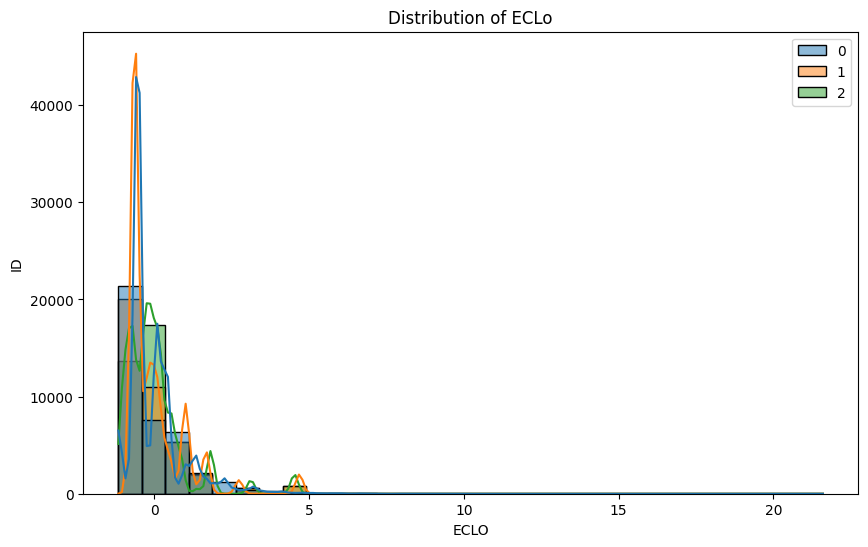

In [ ]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_std, bins=30, kde=True)
plt.title('Distribution of ECLo')
plt.xlabel('ECLO')
plt.ylabel('ID')
plt.show()

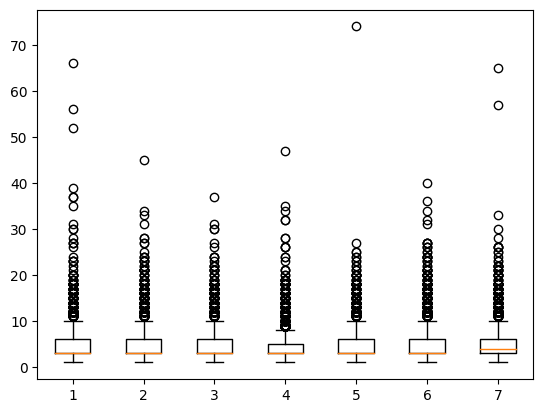

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '토요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '일요일'].loc[:,'ECLO',]])
plt.show()

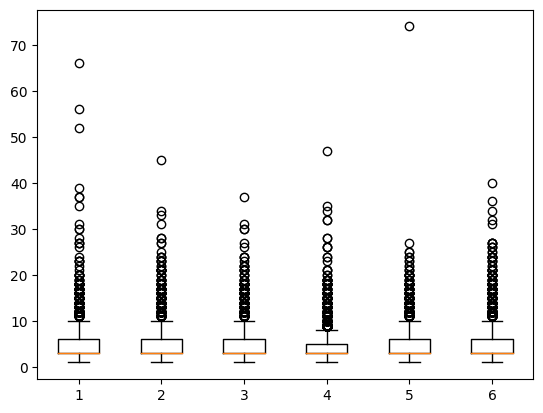

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

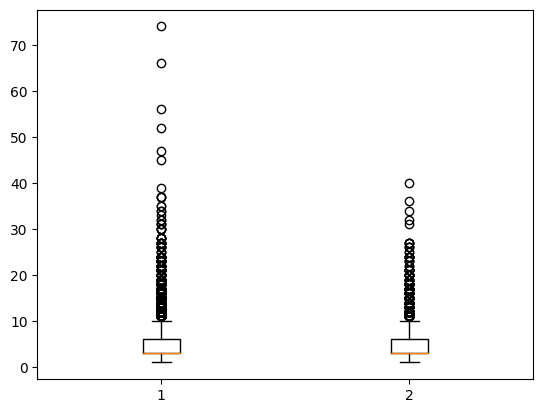

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[(train_df['요일'] == '월요일')|
                      (train_df['요일'] == '화요일')|
                      (train_df['요일'] == '수요일')|
                      (train_df['요일'] == '목요일')|
                      (train_df['요일'] == '금요일')].loc[:,'ECLO'],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

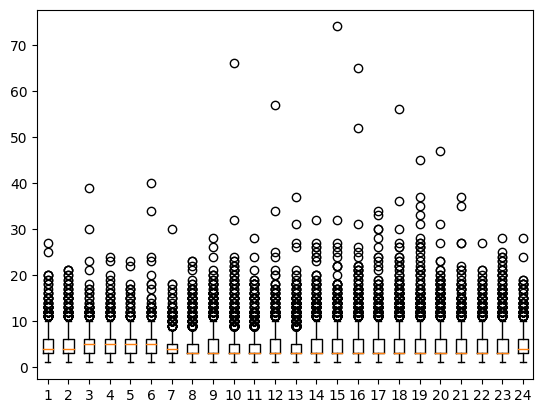

In [ ]:
plt.boxplot([train_df[train_df['시간'] == 0].loc[:,'ECLO',],
              train_df[train_df['시간'] == 1].loc[:,'ECLO',],
              train_df[train_df['시간'] == 2].loc[:,'ECLO'],
              train_df[train_df['시간'] == 3].loc[:,'ECLO',],
              train_df[train_df['시간'] == 4].loc[:,'ECLO',],
              train_df[train_df['시간'] == 5].loc[:,'ECLO',],
              train_df[train_df['시간'] == 6].loc[:,'ECLO',],
             train_df[train_df['시간'] == 7].loc[:,'ECLO',],
             train_df[train_df['시간'] == 8].loc[:,'ECLO',],
             train_df[train_df['시간'] == 9].loc[:,'ECLO',],
             train_df[train_df['시간'] == 10].loc[:,'ECLO',],
             train_df[train_df['시간'] == 11].loc[:,'ECLO',],
             train_df[train_df['시간'] == 12].loc[:,'ECLO',],
             train_df[train_df['시간'] == 13].loc[:,'ECLO',],
             train_df[train_df['시간'] == 14].loc[:,'ECLO',],
             train_df[train_df['시간'] == 15].loc[:,'ECLO',],
             train_df[train_df['시간'] == 16].loc[:,'ECLO',],
             train_df[train_df['시간'] == 17].loc[:,'ECLO',],
             train_df[train_df['시간'] == 18].loc[:,'ECLO',],
             train_df[train_df['시간'] == 19].loc[:,'ECLO',],
             train_df[train_df['시간'] == 20].loc[:,'ECLO',],
             train_df[train_df['시간'] == 21].loc[:,'ECLO',],
             train_df[train_df['시간'] == 22].loc[:,'ECLO',],
             train_df[train_df['시간'] == 23].loc[:,'ECLO',]])
plt.show()

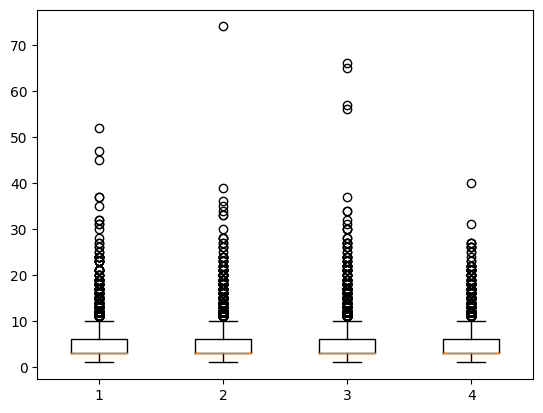

In [ ]:
plt.boxplot([train_df[(train_df['월'] >= 3)&(train_df['월'] <= 5)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 6)&(train_df['월'] <= 8)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 9)&(train_df['월'] <= 11)].loc[:,'ECLO'],
             train_df[(train_df['월'] == 12)|(train_df['월'] >= 1)&(train_df['월'] <= 2)].loc[:,'ECLO']])
plt.show()

피처, 타겟 분리 라벨인코딩

In [77]:
#X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           #'가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별','도시'])
X = train_df.drop(columns=['ID','ECLO'])
y = train_df['ECLO']
test_df = test_df.drop(columns=['ID'])
print(X.shape, y.shape, test_df.shape)

(39609, 15) (39609,) (10963, 15)


In [78]:
from sklearn.preprocessing import LabelEncoder

FEATURE = ['기상상태','노면상태','사고유형','구','동','도로형태1','도로형태2','요일','도시']
for i in FEATURE:
    le = LabelEncoder()
    X[i]= le.fit_transform(X[i])
    test_df[i]= le.transform(test_df[i])

X

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,어린이CCTV설치대수,CCTV개수
0,6,2,0,0,2019,1,1,0,0,7,40,2,5,2.0,1.0
1,6,5,0,0,2019,1,1,0,0,1,4,2,5,0.0,4.0
2,6,2,0,0,2019,1,1,1,0,6,66,2,5,5.0,4.0
3,6,2,0,1,2019,1,1,2,0,4,79,2,5,11.0,10.0
4,6,2,0,1,2019,1,1,4,0,3,129,2,5,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,0,1,2021,12,31,19,0,6,118,0,3,1.0,1.0
39605,0,2,0,1,2021,12,31,19,0,1,103,2,5,0.0,18.0
39606,0,2,0,1,2021,12,31,21,0,1,144,0,3,0.0,9.0
39607,0,2,0,1,2021,12,31,22,0,1,158,1,5,0.0,1.0


In [79]:
test_df

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,어린이CCTV설치대수,CCTV개수
0,5,2,0,0,2022,1,1,1,0,6,99,0,3,5.0,4.0
1,5,2,0,0,2022,1,1,1,0,6,168,2,5,10.0,7.0
2,5,2,0,1,2022,1,1,4,0,6,117,0,3,1.0,1.0
3,5,2,0,1,2022,1,1,4,0,6,126,2,5,7.0,11.0
4,5,2,0,1,2022,1,1,6,0,1,4,0,3,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,5,2,0,1,2022,12,31,18,0,0,38,2,9,26.0,27.0
10959,5,2,0,1,2022,12,31,18,0,6,123,2,5,5.0,4.0
10960,5,2,0,1,2022,12,31,20,0,6,134,2,5,0.0,0.0
10961,5,2,0,1,2022,12,31,20,0,6,77,0,2,7.0,7.0


모델 훈련 및 예측

In [80]:
#xgboost3.csv
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # XGBoost의 하이퍼파라미터를 설정합니다.
    param = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'lambda': trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4,8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
    }

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**param)

    # 모델을 훈련합니다.
    model.fit(X_train, np.log1p(y_train), eval_set=[(X_val,np.log1p(y_val))],early_stopping_rounds=100)

    # 검증 데이터에 대한 예측을 수행합니다.
    y_pred = model.predict(X_val)

    # RMSE를 계산하여 반환합니다.
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.expm1(y_pred)))
    return rmsle

# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행합니다.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터를 출력합니다.
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
final_model = xgb.XGBRegressor(
    objective='reg:squaredlogerror',
    eval_metric='rmsle',
    verbosity=0,
    n_jobs=-1,
    tree_method='hist',
    **best_params
)

final_model.fit(X, y, verbose=False)
y_pred = final_model.predict(test_df)

[I 2023-11-18 12:55:55,511] A new study created in memory with name: no-name-4bc8d308-9525-4b7e-9e2e-58e561d9c85a


[0]	validation_0-rmsle:0.57575
[1]	validation_0-rmsle:0.57028
[2]	validation_0-rmsle:0.56485
[3]	validation_0-rmsle:0.55945
[4]	validation_0-rmsle:0.55410
[5]	validation_0-rmsle:0.54880
[6]	validation_0-rmsle:0.54353
[7]	validation_0-rmsle:0.53831
[8]	validation_0-rmsle:0.53313
[9]	validation_0-rmsle:0.52799
[10]	validation_0-rmsle:0.52289
[11]	validation_0-rmsle:0.51784
[12]	validation_0-rmsle:0.51283
[13]	validation_0-rmsle:0.50786
[14]	validation_0-rmsle:0.50294
[15]	validation_0-rmsle:0.49806
[16]	validation_0-rmsle:0.49322
[17]	validation_0-rmsle:0.48843
[18]	validation_0-rmsle:0.48369
[19]	validation_0-rmsle:0.47898
[20]	validation_0-rmsle:0.47431
[21]	validation_0-rmsle:0.46969
[22]	validation_0-rmsle:0.46511
[23]	validation_0-rmsle:0.46057
[24]	validation_0-rmsle:0.45608
[25]	validation_0-rmsle:0.45162
[26]	validation_0-rmsle:0.44721
[27]	validation_0-rmsle:0.44285
[28]	validation_0-rmsle:0.43852
[29]	validation_0-rmsle:0.43423
[30]	validation_0-rmsle:0.43000
[31]	validation_0-

[I 2023-11-18 12:55:58,524] Trial 0 finished with value: 0.4474566232963786 and parameters: {'lambda': 0.007971069722523108, 'alpha': 0.5154821196362082, 'colsample_bytree': 0.8113459155161513, 'subsample': 0.862670973238642, 'learning_rate': 0.016219540587434474, 'n_estimators': 371, 'max_depth': 6, 'min_child_weight': 45}. Best is trial 0 with value: 0.4474566232963786.


[0]	validation_0-rmsle:0.55063
[1]	validation_0-rmsle:0.52136
[2]	validation_0-rmsle:0.49341
[3]	validation_0-rmsle:0.46680
[4]	validation_0-rmsle:0.44153
[5]	validation_0-rmsle:0.41766
[6]	validation_0-rmsle:0.39510
[7]	validation_0-rmsle:0.37393
[8]	validation_0-rmsle:0.35410
[9]	validation_0-rmsle:0.33552
[10]	validation_0-rmsle:0.31829
[11]	validation_0-rmsle:0.30238
[12]	validation_0-rmsle:0.28771
[13]	validation_0-rmsle:0.27428
[14]	validation_0-rmsle:0.26202
[15]	validation_0-rmsle:0.25090
[16]	validation_0-rmsle:0.24090
[17]	validation_0-rmsle:0.23192
[18]	validation_0-rmsle:0.22393
[19]	validation_0-rmsle:0.21677
[20]	validation_0-rmsle:0.21053
[21]	validation_0-rmsle:0.20503
[22]	validation_0-rmsle:0.20016
[23]	validation_0-rmsle:0.19591
[24]	validation_0-rmsle:0.19230
[25]	validation_0-rmsle:0.18908
[26]	validation_0-rmsle:0.18640
[27]	validation_0-rmsle:0.18413
[28]	validation_0-rmsle:0.18217
[29]	validation_0-rmsle:0.18046
[30]	validation_0-rmsle:0.17904
[31]	validation_0-

[I 2023-11-18 12:56:02,890] Trial 1 finished with value: 0.44691626922476546 and parameters: {'lambda': 0.009455956315657078, 'alpha': 0.5020431096877802, 'colsample_bytree': 0.5253719631972625, 'subsample': 0.7805020981538191, 'learning_rate': 0.09140110368232737, 'n_estimators': 710, 'max_depth': 7, 'min_child_weight': 39}. Best is trial 1 with value: 0.44691626922476546.


[0]	validation_0-rmsle:0.55024
[1]	validation_0-rmsle:0.52057
[2]	validation_0-rmsle:0.49225
[3]	validation_0-rmsle:0.46532
[4]	validation_0-rmsle:0.43976
[5]	validation_0-rmsle:0.41564
[6]	validation_0-rmsle:0.39287
[7]	validation_0-rmsle:0.37152
[8]	validation_0-rmsle:0.35155
[9]	validation_0-rmsle:0.33288
[10]	validation_0-rmsle:0.31556
[11]	validation_0-rmsle:0.29965
[12]	validation_0-rmsle:0.28495
[13]	validation_0-rmsle:0.27157
[14]	validation_0-rmsle:0.25937
[15]	validation_0-rmsle:0.24836
[16]	validation_0-rmsle:0.23846
[17]	validation_0-rmsle:0.22959
[18]	validation_0-rmsle:0.22176
[19]	validation_0-rmsle:0.21471
[20]	validation_0-rmsle:0.20858
[21]	validation_0-rmsle:0.20322
[22]	validation_0-rmsle:0.19853
[23]	validation_0-rmsle:0.19441
[24]	validation_0-rmsle:0.19093
[25]	validation_0-rmsle:0.18786
[26]	validation_0-rmsle:0.18531
[27]	validation_0-rmsle:0.18314
[28]	validation_0-rmsle:0.18129
[29]	validation_0-rmsle:0.17969
[30]	validation_0-rmsle:0.17835
[31]	validation_0-

[I 2023-11-18 12:56:04,600] Trial 2 finished with value: 0.4467840477184101 and parameters: {'lambda': 0.091150838542843, 'alpha': 0.1269967268685276, 'colsample_bytree': 0.42099756554830814, 'subsample': 0.915992664861504, 'learning_rate': 0.09267562052020384, 'n_estimators': 553, 'max_depth': 5, 'min_child_weight': 23}. Best is trial 2 with value: 0.4467840477184101.


[0]	validation_0-rmsle:0.57550
[1]	validation_0-rmsle:0.56978
[2]	validation_0-rmsle:0.56411
[3]	validation_0-rmsle:0.55848
[4]	validation_0-rmsle:0.55290
[5]	validation_0-rmsle:0.54736
[6]	validation_0-rmsle:0.54187
[7]	validation_0-rmsle:0.53643
[8]	validation_0-rmsle:0.53104
[9]	validation_0-rmsle:0.52568
[10]	validation_0-rmsle:0.52038
[11]	validation_0-rmsle:0.51512
[12]	validation_0-rmsle:0.50990
[13]	validation_0-rmsle:0.50474
[14]	validation_0-rmsle:0.49962
[15]	validation_0-rmsle:0.49455
[16]	validation_0-rmsle:0.48953
[17]	validation_0-rmsle:0.48456
[18]	validation_0-rmsle:0.47963
[19]	validation_0-rmsle:0.47474
[20]	validation_0-rmsle:0.46991
[21]	validation_0-rmsle:0.46512
[22]	validation_0-rmsle:0.46038
[23]	validation_0-rmsle:0.45568
[24]	validation_0-rmsle:0.45102
[25]	validation_0-rmsle:0.44642
[26]	validation_0-rmsle:0.44187
[27]	validation_0-rmsle:0.43736
[28]	validation_0-rmsle:0.43290
[29]	validation_0-rmsle:0.42848
[30]	validation_0-rmsle:0.42412
[31]	validation_0-

[I 2023-11-18 12:56:10,855] Trial 3 finished with value: 0.44677309558697753 and parameters: {'lambda': 0.01047521109818008, 'alpha': 0.761176084465399, 'colsample_bytree': 0.5566265888062377, 'subsample': 0.9954124418926508, 'learning_rate': 0.016959149751832915, 'n_estimators': 757, 'max_depth': 5, 'min_child_weight': 4}. Best is trial 3 with value: 0.44677309558697753.


[0]	validation_0-rmsle:0.54921
[1]	validation_0-rmsle:0.51861
[2]	validation_0-rmsle:0.48948
[3]	validation_0-rmsle:0.46179
[4]	validation_0-rmsle:0.43560
[5]	validation_0-rmsle:0.41089
[6]	validation_0-rmsle:0.38763
[7]	validation_0-rmsle:0.36589
[8]	validation_0-rmsle:0.34562
[9]	validation_0-rmsle:0.32676
[10]	validation_0-rmsle:0.30939
[11]	validation_0-rmsle:0.29338
[12]	validation_0-rmsle:0.27878
[13]	validation_0-rmsle:0.26544
[14]	validation_0-rmsle:0.25343
[15]	validation_0-rmsle:0.24260
[16]	validation_0-rmsle:0.23292
[17]	validation_0-rmsle:0.22435
[18]	validation_0-rmsle:0.21672
[19]	validation_0-rmsle:0.21008
[20]	validation_0-rmsle:0.20428
[21]	validation_0-rmsle:0.19923
[22]	validation_0-rmsle:0.19488
[23]	validation_0-rmsle:0.19112
[24]	validation_0-rmsle:0.18795
[25]	validation_0-rmsle:0.18519
[26]	validation_0-rmsle:0.18289
[27]	validation_0-rmsle:0.18096
[28]	validation_0-rmsle:0.17930
[29]	validation_0-rmsle:0.17793
[30]	validation_0-rmsle:0.17679
[31]	validation_0-

[I 2023-11-18 12:56:13,529] Trial 4 finished with value: 0.44727962137640004 and parameters: {'lambda': 0.0536151006105104, 'alpha': 0.11586896982281705, 'colsample_bytree': 0.9985746287589262, 'subsample': 0.7503046031596866, 'learning_rate': 0.0957671547565298, 'n_estimators': 497, 'max_depth': 5, 'min_child_weight': 23}. Best is trial 3 with value: 0.44677309558697753.


[0]	validation_0-rmsle:0.57851
[1]	validation_0-rmsle:0.57577
[2]	validation_0-rmsle:0.57303
[3]	validation_0-rmsle:0.57030
[4]	validation_0-rmsle:0.56759
[5]	validation_0-rmsle:0.56488
[6]	validation_0-rmsle:0.56219
[7]	validation_0-rmsle:0.55951
[8]	validation_0-rmsle:0.55683
[9]	validation_0-rmsle:0.55417
[10]	validation_0-rmsle:0.55151
[11]	validation_0-rmsle:0.54887
[12]	validation_0-rmsle:0.54624
[13]	validation_0-rmsle:0.54362
[14]	validation_0-rmsle:0.54101
[15]	validation_0-rmsle:0.53841
[16]	validation_0-rmsle:0.53582
[17]	validation_0-rmsle:0.53324
[18]	validation_0-rmsle:0.53068
[19]	validation_0-rmsle:0.52812
[20]	validation_0-rmsle:0.52557
[21]	validation_0-rmsle:0.52304
[22]	validation_0-rmsle:0.52052
[23]	validation_0-rmsle:0.51800
[24]	validation_0-rmsle:0.51549
[25]	validation_0-rmsle:0.51299
[26]	validation_0-rmsle:0.51051
[27]	validation_0-rmsle:0.50804
[28]	validation_0-rmsle:0.50558
[29]	validation_0-rmsle:0.50312
[30]	validation_0-rmsle:0.50068
[31]	validation_0-

[I 2023-11-18 12:56:22,135] Trial 5 finished with value: 0.44783446425196544 and parameters: {'lambda': 0.011514771906091063, 'alpha': 0.6506867229329929, 'colsample_bytree': 0.6061881536061113, 'subsample': 0.8510688791631165, 'learning_rate': 0.008095749119475687, 'n_estimators': 712, 'max_depth': 8, 'min_child_weight': 19}. Best is trial 3 with value: 0.44677309558697753.


[0]	validation_0-rmsle:0.57861
[1]	validation_0-rmsle:0.57596
[2]	validation_0-rmsle:0.57331
[3]	validation_0-rmsle:0.57068
[4]	validation_0-rmsle:0.56805
[5]	validation_0-rmsle:0.56544
[6]	validation_0-rmsle:0.56284
[7]	validation_0-rmsle:0.56025
[8]	validation_0-rmsle:0.55766
[9]	validation_0-rmsle:0.55508
[10]	validation_0-rmsle:0.55252
[11]	validation_0-rmsle:0.54997
[12]	validation_0-rmsle:0.54742
[13]	validation_0-rmsle:0.54489
[14]	validation_0-rmsle:0.54236
[15]	validation_0-rmsle:0.53985
[16]	validation_0-rmsle:0.53734
[17]	validation_0-rmsle:0.53485
[18]	validation_0-rmsle:0.53237
[19]	validation_0-rmsle:0.52989
[20]	validation_0-rmsle:0.52743
[21]	validation_0-rmsle:0.52497
[22]	validation_0-rmsle:0.52252
[23]	validation_0-rmsle:0.52008
[24]	validation_0-rmsle:0.51766
[25]	validation_0-rmsle:0.51523
[26]	validation_0-rmsle:0.51283
[27]	validation_0-rmsle:0.51043
[28]	validation_0-rmsle:0.50804
[29]	validation_0-rmsle:0.50567
[30]	validation_0-rmsle:0.50330
[31]	validation_0-

[I 2023-11-18 12:56:24,094] Trial 6 finished with value: 0.5843182330267422 and parameters: {'lambda': 0.053166267183874946, 'alpha': 0.4024569427078022, 'colsample_bytree': 0.5968751736791709, 'subsample': 0.5129884969082058, 'learning_rate': 0.00781744219914623, 'n_estimators': 230, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 3 with value: 0.44677309558697753.


[0]	validation_0-rmsle:0.57497
[1]	validation_0-rmsle:0.56873
[2]	validation_0-rmsle:0.56254
[3]	validation_0-rmsle:0.55641
[4]	validation_0-rmsle:0.55032
[5]	validation_0-rmsle:0.54431
[6]	validation_0-rmsle:0.53834
[7]	validation_0-rmsle:0.53244
[8]	validation_0-rmsle:0.52658
[9]	validation_0-rmsle:0.52077
[10]	validation_0-rmsle:0.51503
[11]	validation_0-rmsle:0.50934
[12]	validation_0-rmsle:0.50371
[13]	validation_0-rmsle:0.49814
[14]	validation_0-rmsle:0.49262
[15]	validation_0-rmsle:0.48715
[16]	validation_0-rmsle:0.48174
[17]	validation_0-rmsle:0.47639
[18]	validation_0-rmsle:0.47111
[19]	validation_0-rmsle:0.46586
[20]	validation_0-rmsle:0.46069
[21]	validation_0-rmsle:0.45556
[22]	validation_0-rmsle:0.45048
[23]	validation_0-rmsle:0.44544
[24]	validation_0-rmsle:0.44048
[25]	validation_0-rmsle:0.43556
[26]	validation_0-rmsle:0.43070
[27]	validation_0-rmsle:0.42592
[28]	validation_0-rmsle:0.42117
[29]	validation_0-rmsle:0.41648
[30]	validation_0-rmsle:0.41186
[31]	validation_0-

[I 2023-11-18 12:56:25,282] Trial 7 finished with value: 0.5001752257565778 and parameters: {'lambda': 0.0014672635716889042, 'alpha': 0.43468859866384535, 'colsample_bytree': 0.5631202861384926, 'subsample': 0.5356333916784972, 'learning_rate': 0.018526624725970203, 'n_estimators': 134, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 3 with value: 0.44677309558697753.


[0]	validation_0-rmsle:0.54996
[1]	validation_0-rmsle:0.52009
[2]	validation_0-rmsle:0.49156
[3]	validation_0-rmsle:0.46440
[4]	validation_0-rmsle:0.43866
[5]	validation_0-rmsle:0.41441
[6]	validation_0-rmsle:0.39147
[7]	validation_0-rmsle:0.37003
[8]	validation_0-rmsle:0.34995
[9]	validation_0-rmsle:0.33126
[10]	validation_0-rmsle:0.31398
[11]	validation_0-rmsle:0.29807
[12]	validation_0-rmsle:0.28346
[13]	validation_0-rmsle:0.27009
[14]	validation_0-rmsle:0.25796
[15]	validation_0-rmsle:0.24694
[16]	validation_0-rmsle:0.23713
[17]	validation_0-rmsle:0.22835
[18]	validation_0-rmsle:0.22057
[19]	validation_0-rmsle:0.21368
[20]	validation_0-rmsle:0.20764
[21]	validation_0-rmsle:0.20234
[22]	validation_0-rmsle:0.19773
[23]	validation_0-rmsle:0.19372
[24]	validation_0-rmsle:0.19034
[25]	validation_0-rmsle:0.18738
[26]	validation_0-rmsle:0.18486
[27]	validation_0-rmsle:0.18279
[28]	validation_0-rmsle:0.18092
[29]	validation_0-rmsle:0.17940
[30]	validation_0-rmsle:0.17813
[31]	validation_0-

[I 2023-11-18 12:56:31,532] Trial 8 finished with value: 0.4472454841008701 and parameters: {'lambda': 0.01971394550952613, 'alpha': 0.7260671178170591, 'colsample_bytree': 0.8558637519604365, 'subsample': 0.5830265287194996, 'learning_rate': 0.09347951869267551, 'n_estimators': 911, 'max_depth': 5, 'min_child_weight': 7}. Best is trial 3 with value: 0.44677309558697753.


[0]	validation_0-rmsle:0.55635
[1]	validation_0-rmsle:0.53232
[2]	validation_0-rmsle:0.50914
[3]	validation_0-rmsle:0.48686
[4]	validation_0-rmsle:0.46545
[5]	validation_0-rmsle:0.44495
[6]	validation_0-rmsle:0.42534
[7]	validation_0-rmsle:0.40664
[8]	validation_0-rmsle:0.38882
[9]	validation_0-rmsle:0.37185
[10]	validation_0-rmsle:0.35576
[11]	validation_0-rmsle:0.34060
[12]	validation_0-rmsle:0.32626
[13]	validation_0-rmsle:0.31282
[14]	validation_0-rmsle:0.30019
[15]	validation_0-rmsle:0.28841
[16]	validation_0-rmsle:0.27744
[17]	validation_0-rmsle:0.26725
[18]	validation_0-rmsle:0.25784
[19]	validation_0-rmsle:0.24909
[20]	validation_0-rmsle:0.24110
[21]	validation_0-rmsle:0.23378
[22]	validation_0-rmsle:0.22709
[23]	validation_0-rmsle:0.22096
[24]	validation_0-rmsle:0.21546
[25]	validation_0-rmsle:0.21042
[26]	validation_0-rmsle:0.20593
[27]	validation_0-rmsle:0.20191
[28]	validation_0-rmsle:0.19832
[29]	validation_0-rmsle:0.19506
[30]	validation_0-rmsle:0.19220
[31]	validation_0-

[I 2023-11-18 12:56:33,863] Trial 9 finished with value: 0.4467908961106036 and parameters: {'lambda': 0.09186173145131597, 'alpha': 0.7727687551819499, 'colsample_bytree': 0.4300904420391374, 'subsample': 0.949247264356557, 'learning_rate': 0.07413645080140897, 'n_estimators': 597, 'max_depth': 5, 'min_child_weight': 3}. Best is trial 3 with value: 0.44677309558697753.


[0]	validation_0-rmsle:0.56885
[1]	validation_0-rmsle:0.55665
[2]	validation_0-rmsle:0.54466
[3]	validation_0-rmsle:0.53287
[4]	validation_0-rmsle:0.52130
[5]	validation_0-rmsle:0.50996
[6]	validation_0-rmsle:0.49881
[7]	validation_0-rmsle:0.48791
[8]	validation_0-rmsle:0.47721
[9]	validation_0-rmsle:0.46673
[10]	validation_0-rmsle:0.45646
[11]	validation_0-rmsle:0.44643
[12]	validation_0-rmsle:0.43662
[13]	validation_0-rmsle:0.42703
[14]	validation_0-rmsle:0.41766
[15]	validation_0-rmsle:0.40849
[16]	validation_0-rmsle:0.39956
[17]	validation_0-rmsle:0.39084
[18]	validation_0-rmsle:0.38235
[19]	validation_0-rmsle:0.37406
[20]	validation_0-rmsle:0.36600
[21]	validation_0-rmsle:0.35815
[22]	validation_0-rmsle:0.35050
[23]	validation_0-rmsle:0.34305
[24]	validation_0-rmsle:0.33582
[25]	validation_0-rmsle:0.32878
[26]	validation_0-rmsle:0.32198
[27]	validation_0-rmsle:0.31540
[28]	validation_0-rmsle:0.30896
[29]	validation_0-rmsle:0.30276
[30]	validation_0-rmsle:0.29677
[31]	validation_0-

[I 2023-11-18 12:56:37,091] Trial 10 finished with value: 0.44714547747701566 and parameters: {'lambda': 0.02851261965674363, 'alpha': 0.8839186864014033, 'colsample_bytree': 0.6956495293518283, 'subsample': 0.658639445162137, 'learning_rate': 0.0366972140673552, 'n_estimators': 987, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 3 with value: 0.44677309558697753.


[0]	validation_0-rmsle:0.56175
[1]	validation_0-rmsle:0.54278
[2]	validation_0-rmsle:0.52433
[3]	validation_0-rmsle:0.50643
[4]	validation_0-rmsle:0.48905
[5]	validation_0-rmsle:0.47223
[6]	validation_0-rmsle:0.45596
[7]	validation_0-rmsle:0.44023
[8]	validation_0-rmsle:0.42504
[9]	validation_0-rmsle:0.41038
[10]	validation_0-rmsle:0.39625
[11]	validation_0-rmsle:0.38270
[12]	validation_0-rmsle:0.36966
[13]	validation_0-rmsle:0.35719
[14]	validation_0-rmsle:0.34521
[15]	validation_0-rmsle:0.33380
[16]	validation_0-rmsle:0.32291
[17]	validation_0-rmsle:0.31255
[18]	validation_0-rmsle:0.30269
[19]	validation_0-rmsle:0.29330
[20]	validation_0-rmsle:0.28444
[21]	validation_0-rmsle:0.27606
[22]	validation_0-rmsle:0.26816
[23]	validation_0-rmsle:0.26067
[24]	validation_0-rmsle:0.25368
[25]	validation_0-rmsle:0.24707
[26]	validation_0-rmsle:0.24093
[27]	validation_0-rmsle:0.23520
[28]	validation_0-rmsle:0.22986
[29]	validation_0-rmsle:0.22484
[30]	validation_0-rmsle:0.22022
[31]	validation_0-

[I 2023-11-18 12:56:42,189] Trial 11 finished with value: 0.44678091824063054 and parameters: {'lambda': 0.08844624534316231, 'alpha': 0.9913550720762491, 'colsample_bytree': 0.41669376452528073, 'subsample': 0.999528102623819, 'learning_rate': 0.05786582622083079, 'n_estimators': 712, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 3 with value: 0.44677309558697753.


[0]	validation_0-rmsle:0.56371
[1]	validation_0-rmsle:0.54659
[2]	validation_0-rmsle:0.52989
[3]	validation_0-rmsle:0.51364
[4]	validation_0-rmsle:0.49781
[5]	validation_0-rmsle:0.48242
[6]	validation_0-rmsle:0.46748
[7]	validation_0-rmsle:0.45298
[8]	validation_0-rmsle:0.43892
[9]	validation_0-rmsle:0.42527
[10]	validation_0-rmsle:0.41206
[11]	validation_0-rmsle:0.39933
[12]	validation_0-rmsle:0.38700
[13]	validation_0-rmsle:0.37514
[14]	validation_0-rmsle:0.36369
[15]	validation_0-rmsle:0.35269
[16]	validation_0-rmsle:0.34212
[17]	validation_0-rmsle:0.33198
[18]	validation_0-rmsle:0.32227
[19]	validation_0-rmsle:0.31294
[20]	validation_0-rmsle:0.30405
[21]	validation_0-rmsle:0.29557
[22]	validation_0-rmsle:0.28749
[23]	validation_0-rmsle:0.27976
[24]	validation_0-rmsle:0.27246
[25]	validation_0-rmsle:0.26549
[26]	validation_0-rmsle:0.25893
[27]	validation_0-rmsle:0.25273
[28]	validation_0-rmsle:0.24688
[29]	validation_0-rmsle:0.24132
[30]	validation_0-rmsle:0.23614
[31]	validation_0-

[I 2023-11-18 12:56:49,280] Trial 12 finished with value: 0.44673394697734287 and parameters: {'lambda': 0.07465035527586054, 'alpha': 0.9756014851547241, 'colsample_bytree': 0.40447330405697723, 'subsample': 0.9837918594211227, 'learning_rate': 0.05200368628606698, 'n_estimators': 817, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 12 with value: 0.44673394697734287.


[0]	validation_0-rmsle:0.56935
[1]	validation_0-rmsle:0.55763
[2]	validation_0-rmsle:0.54610
[3]	validation_0-rmsle:0.53478
[4]	validation_0-rmsle:0.52365
[5]	validation_0-rmsle:0.51273
[6]	validation_0-rmsle:0.50201
[7]	validation_0-rmsle:0.49148
[8]	validation_0-rmsle:0.48117
[9]	validation_0-rmsle:0.47103
[10]	validation_0-rmsle:0.46110
[11]	validation_0-rmsle:0.45139
[12]	validation_0-rmsle:0.44186
[13]	validation_0-rmsle:0.43256
[14]	validation_0-rmsle:0.42343
[15]	validation_0-rmsle:0.41452
[16]	validation_0-rmsle:0.40582
[17]	validation_0-rmsle:0.39731
[18]	validation_0-rmsle:0.38901
[19]	validation_0-rmsle:0.38089
[20]	validation_0-rmsle:0.37299
[21]	validation_0-rmsle:0.36529
[22]	validation_0-rmsle:0.35776
[23]	validation_0-rmsle:0.35043
[24]	validation_0-rmsle:0.34331
[25]	validation_0-rmsle:0.33638
[26]	validation_0-rmsle:0.32965
[27]	validation_0-rmsle:0.32312
[28]	validation_0-rmsle:0.31677
[29]	validation_0-rmsle:0.31060
[30]	validation_0-rmsle:0.30463
[31]	validation_0-

[I 2023-11-18 12:57:00,897] Trial 13 finished with value: 0.4466789891720813 and parameters: {'lambda': 0.06711133894272914, 'alpha': 0.9949056332081241, 'colsample_bytree': 0.502233518019611, 'subsample': 0.9949241375952345, 'learning_rate': 0.035185032208952104, 'n_estimators': 855, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 13 with value: 0.4466789891720813.


[0]	validation_0-rmsle:0.56721
[1]	validation_0-rmsle:0.55344
[2]	validation_0-rmsle:0.53992
[3]	validation_0-rmsle:0.52669
[4]	validation_0-rmsle:0.51373
[5]	validation_0-rmsle:0.50107
[6]	validation_0-rmsle:0.48868
[7]	validation_0-rmsle:0.47657
[8]	validation_0-rmsle:0.46475
[9]	validation_0-rmsle:0.45318
[10]	validation_0-rmsle:0.44190
[11]	validation_0-rmsle:0.43092
[12]	validation_0-rmsle:0.42020
[13]	validation_0-rmsle:0.40978
[14]	validation_0-rmsle:0.39963
[15]	validation_0-rmsle:0.38977
[16]	validation_0-rmsle:0.38019
[17]	validation_0-rmsle:0.37090
[18]	validation_0-rmsle:0.36188
[19]	validation_0-rmsle:0.35311
[20]	validation_0-rmsle:0.34465
[21]	validation_0-rmsle:0.33645
[22]	validation_0-rmsle:0.32850
[23]	validation_0-rmsle:0.32081
[24]	validation_0-rmsle:0.31341
[25]	validation_0-rmsle:0.30623
[26]	validation_0-rmsle:0.29935
[27]	validation_0-rmsle:0.29273
[28]	validation_0-rmsle:0.28636
[29]	validation_0-rmsle:0.28022
[30]	validation_0-rmsle:0.27433
[31]	validation_0-

[I 2023-11-18 12:57:07,008] Trial 14 finished with value: 0.44663395291542 and parameters: {'lambda': 0.07266935927105464, 'alpha': 0.9946495617401366, 'colsample_bytree': 0.4953978852380136, 'subsample': 0.8820573244309031, 'learning_rate': 0.041553119813464184, 'n_estimators': 866, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 14 with value: 0.44663395291542.


[0]	validation_0-rmsle:0.57001
[1]	validation_0-rmsle:0.55893
[2]	validation_0-rmsle:0.54802
[3]	validation_0-rmsle:0.53729
[4]	validation_0-rmsle:0.52673
[5]	validation_0-rmsle:0.51637
[6]	validation_0-rmsle:0.50617
[7]	validation_0-rmsle:0.49616
[8]	validation_0-rmsle:0.48633
[9]	validation_0-rmsle:0.47666
[10]	validation_0-rmsle:0.46717
[11]	validation_0-rmsle:0.45788
[12]	validation_0-rmsle:0.44875
[13]	validation_0-rmsle:0.43982
[14]	validation_0-rmsle:0.43106
[15]	validation_0-rmsle:0.42248
[16]	validation_0-rmsle:0.41409
[17]	validation_0-rmsle:0.40588
[18]	validation_0-rmsle:0.39786
[19]	validation_0-rmsle:0.38998
[20]	validation_0-rmsle:0.38232
[21]	validation_0-rmsle:0.37483
[22]	validation_0-rmsle:0.36749
[23]	validation_0-rmsle:0.36032
[24]	validation_0-rmsle:0.35336
[25]	validation_0-rmsle:0.34653
[26]	validation_0-rmsle:0.33991
[27]	validation_0-rmsle:0.33346
[28]	validation_0-rmsle:0.32719
[29]	validation_0-rmsle:0.32106
[30]	validation_0-rmsle:0.31512
[31]	validation_0-

[I 2023-11-18 12:57:16,923] Trial 15 finished with value: 0.44665661783865285 and parameters: {'lambda': 0.06972549281299305, 'alpha': 0.8947644158316784, 'colsample_bytree': 0.4879924348920962, 'subsample': 0.8806825521694716, 'learning_rate': 0.03322420829389211, 'n_estimators': 884, 'max_depth': 4, 'min_child_weight': 30}. Best is trial 14 with value: 0.44663395291542.


[0]	validation_0-rmsle:0.56933
[1]	validation_0-rmsle:0.55760
[2]	validation_0-rmsle:0.54606
[3]	validation_0-rmsle:0.53472
[4]	validation_0-rmsle:0.52356
[5]	validation_0-rmsle:0.51266
[6]	validation_0-rmsle:0.50192
[7]	validation_0-rmsle:0.49138
[8]	validation_0-rmsle:0.48106
[9]	validation_0-rmsle:0.47090
[10]	validation_0-rmsle:0.46098
[11]	validation_0-rmsle:0.45128
[12]	validation_0-rmsle:0.44176
[13]	validation_0-rmsle:0.43244
[14]	validation_0-rmsle:0.42331
[15]	validation_0-rmsle:0.41438
[16]	validation_0-rmsle:0.40567
[17]	validation_0-rmsle:0.39716
[18]	validation_0-rmsle:0.38888
[19]	validation_0-rmsle:0.38076
[20]	validation_0-rmsle:0.37284
[21]	validation_0-rmsle:0.36512
[22]	validation_0-rmsle:0.35761
[23]	validation_0-rmsle:0.35028
[24]	validation_0-rmsle:0.34317
[25]	validation_0-rmsle:0.33621
[26]	validation_0-rmsle:0.32947
[27]	validation_0-rmsle:0.32295
[28]	validation_0-rmsle:0.31656
[29]	validation_0-rmsle:0.31038
[30]	validation_0-rmsle:0.30441
[31]	validation_0-

[I 2023-11-18 12:57:21,793] Trial 16 finished with value: 0.4471447797363383 and parameters: {'lambda': 0.07338069962984885, 'alpha': 0.8689746811255623, 'colsample_bytree': 0.4824709121048207, 'subsample': 0.4156325590117159, 'learning_rate': 0.03525849175161898, 'n_estimators': 990, 'max_depth': 6, 'min_child_weight': 49}. Best is trial 14 with value: 0.44663395291542.


[0]	validation_0-rmsle:0.56645
[1]	validation_0-rmsle:0.55196
[2]	validation_0-rmsle:0.53775
[3]	validation_0-rmsle:0.52385
[4]	validation_0-rmsle:0.51025
[5]	validation_0-rmsle:0.49699
[6]	validation_0-rmsle:0.48403
[7]	validation_0-rmsle:0.47139
[8]	validation_0-rmsle:0.45906
[9]	validation_0-rmsle:0.44701
[10]	validation_0-rmsle:0.43529
[11]	validation_0-rmsle:0.42388
[12]	validation_0-rmsle:0.41278
[13]	validation_0-rmsle:0.40200
[14]	validation_0-rmsle:0.39153
[15]	validation_0-rmsle:0.38139
[16]	validation_0-rmsle:0.37155
[17]	validation_0-rmsle:0.36202
[18]	validation_0-rmsle:0.35280
[19]	validation_0-rmsle:0.34386
[20]	validation_0-rmsle:0.33526
[21]	validation_0-rmsle:0.32695
[22]	validation_0-rmsle:0.31890
[23]	validation_0-rmsle:0.31115
[24]	validation_0-rmsle:0.30369
[25]	validation_0-rmsle:0.29650
[26]	validation_0-rmsle:0.28963
[27]	validation_0-rmsle:0.28303
[28]	validation_0-rmsle:0.27671
[29]	validation_0-rmsle:0.27064
[30]	validation_0-rmsle:0.26485
[31]	validation_0-

[I 2023-11-18 12:57:29,021] Trial 17 finished with value: 0.4466671740399306 and parameters: {'lambda': 0.06320460587082569, 'alpha': 0.8567264139536825, 'colsample_bytree': 0.636565154161018, 'subsample': 0.8678449935064589, 'learning_rate': 0.04380200170164298, 'n_estimators': 896, 'max_depth': 4, 'min_child_weight': 37}. Best is trial 14 with value: 0.44663395291542.


[0]	validation_0-rmsle:0.56119
[1]	validation_0-rmsle:0.54170
[2]	validation_0-rmsle:0.52276
[3]	validation_0-rmsle:0.50439
[4]	validation_0-rmsle:0.48659
[5]	validation_0-rmsle:0.46939
[6]	validation_0-rmsle:0.45274
[7]	validation_0-rmsle:0.43669
[8]	validation_0-rmsle:0.42121
[9]	validation_0-rmsle:0.40626
[10]	validation_0-rmsle:0.39191
[11]	validation_0-rmsle:0.37815
[12]	validation_0-rmsle:0.36494
[13]	validation_0-rmsle:0.35232
[14]	validation_0-rmsle:0.34024
[15]	validation_0-rmsle:0.32873
[16]	validation_0-rmsle:0.31778
[17]	validation_0-rmsle:0.30737
[18]	validation_0-rmsle:0.29750
[19]	validation_0-rmsle:0.28812
[20]	validation_0-rmsle:0.27932
[21]	validation_0-rmsle:0.27101
[22]	validation_0-rmsle:0.26314
[23]	validation_0-rmsle:0.25575
[24]	validation_0-rmsle:0.24886
[25]	validation_0-rmsle:0.24234
[26]	validation_0-rmsle:0.23632
[27]	validation_0-rmsle:0.23075
[28]	validation_0-rmsle:0.22555
[29]	validation_0-rmsle:0.22071
[30]	validation_0-rmsle:0.21625
[31]	validation_0-

[I 2023-11-18 12:57:34,094] Trial 18 finished with value: 0.4468963163085485 and parameters: {'lambda': 0.038598588874214294, 'alpha': 0.6351470540079176, 'colsample_bytree': 0.48527171737595787, 'subsample': 0.7980682092437222, 'learning_rate': 0.059529519778162135, 'n_estimators': 638, 'max_depth': 7, 'min_child_weight': 28}. Best is trial 14 with value: 0.44663395291542.


[0]	validation_0-rmsle:0.57224
[1]	validation_0-rmsle:0.56332
[2]	validation_0-rmsle:0.55452
[3]	validation_0-rmsle:0.54583
[4]	validation_0-rmsle:0.53725
[5]	validation_0-rmsle:0.52879
[6]	validation_0-rmsle:0.52043
[7]	validation_0-rmsle:0.51221
[8]	validation_0-rmsle:0.50409
[9]	validation_0-rmsle:0.49608
[10]	validation_0-rmsle:0.48819
[11]	validation_0-rmsle:0.48041
[12]	validation_0-rmsle:0.47275
[13]	validation_0-rmsle:0.46521
[14]	validation_0-rmsle:0.45778
[15]	validation_0-rmsle:0.45047
[16]	validation_0-rmsle:0.44327
[17]	validation_0-rmsle:0.43619
[18]	validation_0-rmsle:0.42923
[19]	validation_0-rmsle:0.42237
[20]	validation_0-rmsle:0.41565
[21]	validation_0-rmsle:0.40903
[22]	validation_0-rmsle:0.40252
[23]	validation_0-rmsle:0.39612
[24]	validation_0-rmsle:0.38984
[25]	validation_0-rmsle:0.38365
[26]	validation_0-rmsle:0.37761
[27]	validation_0-rmsle:0.37167
[28]	validation_0-rmsle:0.36583
[29]	validation_0-rmsle:0.36011
[30]	validation_0-rmsle:0.35452
[31]	validation_0-

[I 2023-11-18 12:57:39,279] Trial 19 finished with value: 0.44679953819198753 and parameters: {'lambda': 0.08084470632925103, 'alpha': 0.9096780348877782, 'colsample_bytree': 0.6486058200908572, 'subsample': 0.7178548445210238, 'learning_rate': 0.0266182922036644, 'n_estimators': 401, 'max_depth': 6, 'min_child_weight': 42}. Best is trial 14 with value: 0.44663395291542.


[0]	validation_0-rmsle:0.58042
[1]	validation_0-rmsle:0.57957
[2]	validation_0-rmsle:0.57872
[3]	validation_0-rmsle:0.57787
[4]	validation_0-rmsle:0.57702
[5]	validation_0-rmsle:0.57618
[6]	validation_0-rmsle:0.57533
[7]	validation_0-rmsle:0.57449
[8]	validation_0-rmsle:0.57364
[9]	validation_0-rmsle:0.57280
[10]	validation_0-rmsle:0.57196
[11]	validation_0-rmsle:0.57112
[12]	validation_0-rmsle:0.57028
[13]	validation_0-rmsle:0.56944
[14]	validation_0-rmsle:0.56860
[15]	validation_0-rmsle:0.56777
[16]	validation_0-rmsle:0.56693
[17]	validation_0-rmsle:0.56610
[18]	validation_0-rmsle:0.56526
[19]	validation_0-rmsle:0.56443
[20]	validation_0-rmsle:0.56360
[21]	validation_0-rmsle:0.56277
[22]	validation_0-rmsle:0.56194
[23]	validation_0-rmsle:0.56111
[24]	validation_0-rmsle:0.56028
[25]	validation_0-rmsle:0.55946
[26]	validation_0-rmsle:0.55863
[27]	validation_0-rmsle:0.55781
[28]	validation_0-rmsle:0.55698
[29]	validation_0-rmsle:0.55616
[30]	validation_0-rmsle:0.55534
[31]	validation_0-

[I 2023-11-18 12:57:51,322] Trial 20 finished with value: 0.5520490771161655 and parameters: {'lambda': 0.06012425277262582, 'alpha': 0.8025108504281586, 'colsample_bytree': 0.47268036260077256, 'subsample': 0.9207321667249381, 'learning_rate': 0.0024972418400068773, 'n_estimators': 802, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 14 with value: 0.44663395291542.


[0]	validation_0-rmsle:0.56620
[1]	validation_0-rmsle:0.55148
[2]	validation_0-rmsle:0.53705
[3]	validation_0-rmsle:0.52293
[4]	validation_0-rmsle:0.50914
[5]	validation_0-rmsle:0.49568
[6]	validation_0-rmsle:0.48254
[7]	validation_0-rmsle:0.46973
[8]	validation_0-rmsle:0.45724
[9]	validation_0-rmsle:0.44504
[10]	validation_0-rmsle:0.43318
[11]	validation_0-rmsle:0.42164
[12]	validation_0-rmsle:0.41042
[13]	validation_0-rmsle:0.39953
[14]	validation_0-rmsle:0.38896
[15]	validation_0-rmsle:0.37873
[16]	validation_0-rmsle:0.36881
[17]	validation_0-rmsle:0.35921
[18]	validation_0-rmsle:0.34993
[19]	validation_0-rmsle:0.34093
[20]	validation_0-rmsle:0.33229
[21]	validation_0-rmsle:0.32396
[22]	validation_0-rmsle:0.31589
[23]	validation_0-rmsle:0.30812
[24]	validation_0-rmsle:0.30065
[25]	validation_0-rmsle:0.29345
[26]	validation_0-rmsle:0.28660
[27]	validation_0-rmsle:0.28001
[28]	validation_0-rmsle:0.27371
[29]	validation_0-rmsle:0.26767
[30]	validation_0-rmsle:0.26192
[31]	validation_0-

[I 2023-11-18 12:57:57,888] Trial 21 finished with value: 0.44660417014991377 and parameters: {'lambda': 0.06724955840237024, 'alpha': 0.8681252510691944, 'colsample_bytree': 0.6345324830326418, 'subsample': 0.8493426019468926, 'learning_rate': 0.04453472840731722, 'n_estimators': 919, 'max_depth': 4, 'min_child_weight': 34}. Best is trial 21 with value: 0.44660417014991377.


[0]	validation_0-rmsle:0.56615
[1]	validation_0-rmsle:0.55137
[2]	validation_0-rmsle:0.53690
[3]	validation_0-rmsle:0.52275
[4]	validation_0-rmsle:0.50891
[5]	validation_0-rmsle:0.49542
[6]	validation_0-rmsle:0.48224
[7]	validation_0-rmsle:0.46940
[8]	validation_0-rmsle:0.45688
[9]	validation_0-rmsle:0.44466
[10]	validation_0-rmsle:0.43277
[11]	validation_0-rmsle:0.42120
[12]	validation_0-rmsle:0.40996
[13]	validation_0-rmsle:0.39905
[14]	validation_0-rmsle:0.38847
[15]	validation_0-rmsle:0.37822
[16]	validation_0-rmsle:0.36828
[17]	validation_0-rmsle:0.35867
[18]	validation_0-rmsle:0.34938
[19]	validation_0-rmsle:0.34038
[20]	validation_0-rmsle:0.33173
[21]	validation_0-rmsle:0.32339
[22]	validation_0-rmsle:0.31531
[23]	validation_0-rmsle:0.30755
[24]	validation_0-rmsle:0.30008
[25]	validation_0-rmsle:0.29288
[26]	validation_0-rmsle:0.28602
[27]	validation_0-rmsle:0.27943
[28]	validation_0-rmsle:0.27314
[29]	validation_0-rmsle:0.26711
[30]	validation_0-rmsle:0.26136
[31]	validation_0-

[I 2023-11-18 12:58:06,944] Trial 22 finished with value: 0.4466890129925737 and parameters: {'lambda': 0.07761206016312627, 'alpha': 0.9307148601681453, 'colsample_bytree': 0.5409679065966082, 'subsample': 0.8193409304311183, 'learning_rate': 0.04468270567745235, 'n_estimators': 920, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 21 with value: 0.44660417014991377.


[0]	validation_0-rmsle:0.57161
[1]	validation_0-rmsle:0.56208
[2]	validation_0-rmsle:0.55267
[3]	validation_0-rmsle:0.54339
[4]	validation_0-rmsle:0.53425
[5]	validation_0-rmsle:0.52524
[6]	validation_0-rmsle:0.51636
[7]	validation_0-rmsle:0.50761
[8]	validation_0-rmsle:0.49900
[9]	validation_0-rmsle:0.49050
[10]	validation_0-rmsle:0.48214
[11]	validation_0-rmsle:0.47391
[12]	validation_0-rmsle:0.46582
[13]	validation_0-rmsle:0.45786
[14]	validation_0-rmsle:0.45003
[15]	validation_0-rmsle:0.44234
[16]	validation_0-rmsle:0.43479
[17]	validation_0-rmsle:0.42737
[18]	validation_0-rmsle:0.42008
[19]	validation_0-rmsle:0.41291
[20]	validation_0-rmsle:0.40589
[21]	validation_0-rmsle:0.39900
[22]	validation_0-rmsle:0.39222
[23]	validation_0-rmsle:0.38557
[24]	validation_0-rmsle:0.37906
[25]	validation_0-rmsle:0.37267
[26]	validation_0-rmsle:0.36642
[27]	validation_0-rmsle:0.36030
[28]	validation_0-rmsle:0.35431
[29]	validation_0-rmsle:0.34844
[30]	validation_0-rmsle:0.34271
[31]	validation_0-

[I 2023-11-18 12:58:15,658] Trial 23 finished with value: 0.4466534020482048 and parameters: {'lambda': 0.06698242801322553, 'alpha': 0.8485157920081743, 'colsample_bytree': 0.5663506932886848, 'subsample': 0.8882836006872677, 'learning_rate': 0.028486910659374007, 'n_estimators': 982, 'max_depth': 4, 'min_child_weight': 33}. Best is trial 21 with value: 0.44660417014991377.


[0]	validation_0-rmsle:0.57216
[1]	validation_0-rmsle:0.56319
[2]	validation_0-rmsle:0.55431
[3]	validation_0-rmsle:0.54556
[4]	validation_0-rmsle:0.53692
[5]	validation_0-rmsle:0.52840
[6]	validation_0-rmsle:0.51999
[7]	validation_0-rmsle:0.51171
[8]	validation_0-rmsle:0.50354
[9]	validation_0-rmsle:0.49548
[10]	validation_0-rmsle:0.48753
[11]	validation_0-rmsle:0.47970
[12]	validation_0-rmsle:0.47199
[13]	validation_0-rmsle:0.46440
[14]	validation_0-rmsle:0.45693
[15]	validation_0-rmsle:0.44959
[16]	validation_0-rmsle:0.44235
[17]	validation_0-rmsle:0.43524
[18]	validation_0-rmsle:0.42824
[19]	validation_0-rmsle:0.42135
[20]	validation_0-rmsle:0.41460
[21]	validation_0-rmsle:0.40796
[22]	validation_0-rmsle:0.40141
[23]	validation_0-rmsle:0.39499
[24]	validation_0-rmsle:0.38868
[25]	validation_0-rmsle:0.38247
[26]	validation_0-rmsle:0.37640
[27]	validation_0-rmsle:0.37044
[28]	validation_0-rmsle:0.36460
[29]	validation_0-rmsle:0.35886
[30]	validation_0-rmsle:0.35324
[31]	validation_0-

[I 2023-11-18 12:58:25,522] Trial 24 finished with value: 0.4466695413939173 and parameters: {'lambda': 0.0984616620669339, 'alpha': 0.8135492284000234, 'colsample_bytree': 0.580726520915012, 'subsample': 0.8290825365386258, 'learning_rate': 0.026818307490414143, 'n_estimators': 990, 'max_depth': 5, 'min_child_weight': 35}. Best is trial 21 with value: 0.44660417014991377.


[0]	validation_0-rmsle:0.56628
[1]	validation_0-rmsle:0.55161
[2]	validation_0-rmsle:0.53724
[3]	validation_0-rmsle:0.52318
[4]	validation_0-rmsle:0.50944
[5]	validation_0-rmsle:0.49602
[6]	validation_0-rmsle:0.48291
[7]	validation_0-rmsle:0.47013
[8]	validation_0-rmsle:0.45766
[9]	validation_0-rmsle:0.44551
[10]	validation_0-rmsle:0.43369
[11]	validation_0-rmsle:0.42218
[12]	validation_0-rmsle:0.41100
[13]	validation_0-rmsle:0.40015
[14]	validation_0-rmsle:0.38961
[15]	validation_0-rmsle:0.37940
[16]	validation_0-rmsle:0.36951
[17]	validation_0-rmsle:0.35993
[18]	validation_0-rmsle:0.35067
[19]	validation_0-rmsle:0.34169
[20]	validation_0-rmsle:0.33304
[21]	validation_0-rmsle:0.32471
[22]	validation_0-rmsle:0.31665
[23]	validation_0-rmsle:0.30889
[24]	validation_0-rmsle:0.30143
[25]	validation_0-rmsle:0.29425
[26]	validation_0-rmsle:0.28739
[27]	validation_0-rmsle:0.28079
[28]	validation_0-rmsle:0.27448
[29]	validation_0-rmsle:0.26844
[30]	validation_0-rmsle:0.26269
[31]	validation_0-

[I 2023-11-18 12:58:30,581] Trial 25 finished with value: 0.4465818113231128 and parameters: {'lambda': 0.06423889106769515, 'alpha': 0.9999702899392279, 'colsample_bytree': 0.6675658660140947, 'subsample': 0.9074169403364482, 'learning_rate': 0.04433138894449913, 'n_estimators': 776, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56619
[1]	validation_0-rmsle:0.55143
[2]	validation_0-rmsle:0.53698
[3]	validation_0-rmsle:0.52284
[4]	validation_0-rmsle:0.50902
[5]	validation_0-rmsle:0.49553
[6]	validation_0-rmsle:0.48235
[7]	validation_0-rmsle:0.46950
[8]	validation_0-rmsle:0.45698
[9]	validation_0-rmsle:0.44477
[10]	validation_0-rmsle:0.43289
[11]	validation_0-rmsle:0.42133
[12]	validation_0-rmsle:0.41010
[13]	validation_0-rmsle:0.39921
[14]	validation_0-rmsle:0.38864
[15]	validation_0-rmsle:0.37839
[16]	validation_0-rmsle:0.36847
[17]	validation_0-rmsle:0.35886
[18]	validation_0-rmsle:0.34958
[19]	validation_0-rmsle:0.34058
[20]	validation_0-rmsle:0.33192
[21]	validation_0-rmsle:0.32358
[22]	validation_0-rmsle:0.31551
[23]	validation_0-rmsle:0.30774
[24]	validation_0-rmsle:0.30028
[25]	validation_0-rmsle:0.29310
[26]	validation_0-rmsle:0.28624
[27]	validation_0-rmsle:0.27965
[28]	validation_0-rmsle:0.27334
[29]	validation_0-rmsle:0.26732
[30]	validation_0-rmsle:0.26158
[31]	validation_0-

[I 2023-11-18 12:58:37,048] Trial 26 finished with value: 0.4468695712126864 and parameters: {'lambda': 0.04597806428884688, 'alpha': 0.9708376420524346, 'colsample_bytree': 0.6912590073532108, 'subsample': 0.9355142511985701, 'learning_rate': 0.04460633805530668, 'n_estimators': 789, 'max_depth': 8, 'min_child_weight': 46}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56339
[1]	validation_0-rmsle:0.54598
[2]	validation_0-rmsle:0.52901
[3]	validation_0-rmsle:0.51248
[4]	validation_0-rmsle:0.49640
[5]	validation_0-rmsle:0.48079
[6]	validation_0-rmsle:0.46560
[7]	validation_0-rmsle:0.45089
[8]	validation_0-rmsle:0.43663
[9]	validation_0-rmsle:0.42281
[10]	validation_0-rmsle:0.40947
[11]	validation_0-rmsle:0.39657
[12]	validation_0-rmsle:0.38414
[13]	validation_0-rmsle:0.37215
[14]	validation_0-rmsle:0.36062
[15]	validation_0-rmsle:0.34953
[16]	validation_0-rmsle:0.33890
[17]	validation_0-rmsle:0.32869
[18]	validation_0-rmsle:0.31894
[19]	validation_0-rmsle:0.30959
[20]	validation_0-rmsle:0.30071
[21]	validation_0-rmsle:0.29223
[22]	validation_0-rmsle:0.28414
[23]	validation_0-rmsle:0.27643
[24]	validation_0-rmsle:0.26914
[25]	validation_0-rmsle:0.26219
[26]	validation_0-rmsle:0.25568
[27]	validation_0-rmsle:0.24952
[28]	validation_0-rmsle:0.24369
[29]	validation_0-rmsle:0.23823
[30]	validation_0-rmsle:0.23310
[31]	validation_0-

[I 2023-11-18 12:58:41,866] Trial 27 finished with value: 0.4467446944512675 and parameters: {'lambda': 0.058146104234649776, 'alpha': 0.9971909537882514, 'colsample_bytree': 0.7459102754961436, 'subsample': 0.7799834933466975, 'learning_rate': 0.05293400219920399, 'n_estimators': 669, 'max_depth': 5, 'min_child_weight': 42}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.55974
[1]	validation_0-rmsle:0.53889
[2]	validation_0-rmsle:0.51866
[3]	validation_0-rmsle:0.49909
[4]	validation_0-rmsle:0.48017
[5]	validation_0-rmsle:0.46193
[6]	validation_0-rmsle:0.44433
[7]	validation_0-rmsle:0.42741
[8]	validation_0-rmsle:0.41115
[9]	validation_0-rmsle:0.39553
[10]	validation_0-rmsle:0.38059
[11]	validation_0-rmsle:0.36632
[12]	validation_0-rmsle:0.35268
[13]	validation_0-rmsle:0.33971
[14]	validation_0-rmsle:0.32739
[15]	validation_0-rmsle:0.31572
[16]	validation_0-rmsle:0.30466
[17]	validation_0-rmsle:0.29421
[18]	validation_0-rmsle:0.28438
[19]	validation_0-rmsle:0.27512
[20]	validation_0-rmsle:0.26647
[21]	validation_0-rmsle:0.25838
[22]	validation_0-rmsle:0.25077
[23]	validation_0-rmsle:0.24369
[24]	validation_0-rmsle:0.23713
[25]	validation_0-rmsle:0.23101
[26]	validation_0-rmsle:0.22542
[27]	validation_0-rmsle:0.22025
[28]	validation_0-rmsle:0.21547
[29]	validation_0-rmsle:0.21112
[30]	validation_0-rmsle:0.20714
[31]	validation_0-

[I 2023-11-18 12:58:49,159] Trial 28 finished with value: 0.4467448688398099 and parameters: {'lambda': 0.08187170817645499, 'alpha': 0.9186643539131815, 'colsample_bytree': 0.6678652305412224, 'subsample': 0.8356845429469734, 'learning_rate': 0.06388886929978571, 'n_estimators': 838, 'max_depth': 4, 'min_child_weight': 49}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56710
[1]	validation_0-rmsle:0.55323
[2]	validation_0-rmsle:0.53962
[3]	validation_0-rmsle:0.52628
[4]	validation_0-rmsle:0.51323
[5]	validation_0-rmsle:0.50047
[6]	validation_0-rmsle:0.48798
[7]	validation_0-rmsle:0.47578
[8]	validation_0-rmsle:0.46387
[9]	validation_0-rmsle:0.45224
[10]	validation_0-rmsle:0.44089
[11]	validation_0-rmsle:0.42984
[12]	validation_0-rmsle:0.41907
[13]	validation_0-rmsle:0.40859
[14]	validation_0-rmsle:0.39839
[15]	validation_0-rmsle:0.38850
[16]	validation_0-rmsle:0.37888
[17]	validation_0-rmsle:0.36954
[18]	validation_0-rmsle:0.36049
[19]	validation_0-rmsle:0.35170
[20]	validation_0-rmsle:0.34321
[21]	validation_0-rmsle:0.33500
[22]	validation_0-rmsle:0.32704
[23]	validation_0-rmsle:0.31933
[24]	validation_0-rmsle:0.31191
[25]	validation_0-rmsle:0.30473
[26]	validation_0-rmsle:0.29784
[27]	validation_0-rmsle:0.29121
[28]	validation_0-rmsle:0.28481
[29]	validation_0-rmsle:0.27867
[30]	validation_0-rmsle:0.27279
[31]	validation_0-

[I 2023-11-18 12:58:56,964] Trial 29 finished with value: 0.44668472694236566 and parameters: {'lambda': 0.044880773863115384, 'alpha': 0.7201041870684495, 'colsample_bytree': 0.7442425129854116, 'subsample': 0.8658717849074445, 'learning_rate': 0.04186773754197684, 'n_estimators': 433, 'max_depth': 6, 'min_child_weight': 43}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56475
[1]	validation_0-rmsle:0.54863
[2]	validation_0-rmsle:0.53286
[3]	validation_0-rmsle:0.51747
[4]	validation_0-rmsle:0.50248
[5]	validation_0-rmsle:0.48789
[6]	validation_0-rmsle:0.47368
[7]	validation_0-rmsle:0.45986
[8]	validation_0-rmsle:0.44644
[9]	validation_0-rmsle:0.43337
[10]	validation_0-rmsle:0.42070
[11]	validation_0-rmsle:0.40842
[12]	validation_0-rmsle:0.39653
[13]	validation_0-rmsle:0.38505
[14]	validation_0-rmsle:0.37393
[15]	validation_0-rmsle:0.36322
[16]	validation_0-rmsle:0.35289
[17]	validation_0-rmsle:0.34294
[18]	validation_0-rmsle:0.33338
[19]	validation_0-rmsle:0.32415
[20]	validation_0-rmsle:0.31533
[21]	validation_0-rmsle:0.30686
[22]	validation_0-rmsle:0.29874
[23]	validation_0-rmsle:0.29095
[24]	validation_0-rmsle:0.28353
[25]	validation_0-rmsle:0.27642
[26]	validation_0-rmsle:0.26970
[27]	validation_0-rmsle:0.26328
[28]	validation_0-rmsle:0.25721
[29]	validation_0-rmsle:0.25142
[30]	validation_0-rmsle:0.24596
[31]	validation_0-

[I 2023-11-18 12:59:00,950] Trial 30 finished with value: 0.44672475047802335 and parameters: {'lambda': 0.06250153928883999, 'alpha': 0.9333681495984085, 'colsample_bytree': 0.6304520306655124, 'subsample': 0.8883245304602505, 'learning_rate': 0.048895512517658835, 'n_estimators': 266, 'max_depth': 5, 'min_child_weight': 25}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.57142
[1]	validation_0-rmsle:0.56170
[2]	validation_0-rmsle:0.55211
[3]	validation_0-rmsle:0.54266
[4]	validation_0-rmsle:0.53334
[5]	validation_0-rmsle:0.52417
[6]	validation_0-rmsle:0.51513
[7]	validation_0-rmsle:0.50623
[8]	validation_0-rmsle:0.49747
[9]	validation_0-rmsle:0.48883
[10]	validation_0-rmsle:0.48033
[11]	validation_0-rmsle:0.47197
[12]	validation_0-rmsle:0.46374
[13]	validation_0-rmsle:0.45567
[14]	validation_0-rmsle:0.44772
[15]	validation_0-rmsle:0.43992
[16]	validation_0-rmsle:0.43226
[17]	validation_0-rmsle:0.42474
[18]	validation_0-rmsle:0.41736
[19]	validation_0-rmsle:0.41010
[20]	validation_0-rmsle:0.40299
[21]	validation_0-rmsle:0.39602
[22]	validation_0-rmsle:0.38917
[23]	validation_0-rmsle:0.38245
[24]	validation_0-rmsle:0.37587
[25]	validation_0-rmsle:0.36942
[26]	validation_0-rmsle:0.36312
[27]	validation_0-rmsle:0.35694
[28]	validation_0-rmsle:0.35091
[29]	validation_0-rmsle:0.34500
[30]	validation_0-rmsle:0.33924
[31]	validation_0-

[I 2023-11-18 12:59:13,592] Trial 31 finished with value: 0.44677708931607574 and parameters: {'lambda': 0.06818403467156205, 'alpha': 0.8492831476343099, 'colsample_bytree': 0.5784506863796494, 'subsample': 0.8939252251522766, 'learning_rate': 0.029053210163834383, 'n_estimators': 948, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.57322
[1]	validation_0-rmsle:0.56526
[2]	validation_0-rmsle:0.55739
[3]	validation_0-rmsle:0.54961
[4]	validation_0-rmsle:0.54191
[5]	validation_0-rmsle:0.53431
[6]	validation_0-rmsle:0.52680
[7]	validation_0-rmsle:0.51939
[8]	validation_0-rmsle:0.51207
[9]	validation_0-rmsle:0.50482
[10]	validation_0-rmsle:0.49767
[11]	validation_0-rmsle:0.49062
[12]	validation_0-rmsle:0.48365
[13]	validation_0-rmsle:0.47679
[14]	validation_0-rmsle:0.47001
[15]	validation_0-rmsle:0.46332
[16]	validation_0-rmsle:0.45673
[17]	validation_0-rmsle:0.45023
[18]	validation_0-rmsle:0.44383
[19]	validation_0-rmsle:0.43751
[20]	validation_0-rmsle:0.43128
[21]	validation_0-rmsle:0.42515
[22]	validation_0-rmsle:0.41910
[23]	validation_0-rmsle:0.41314
[24]	validation_0-rmsle:0.40728
[25]	validation_0-rmsle:0.40150
[26]	validation_0-rmsle:0.39582
[27]	validation_0-rmsle:0.39024
[28]	validation_0-rmsle:0.38475
[29]	validation_0-rmsle:0.37933
[30]	validation_0-rmsle:0.37401
[31]	validation_0-

[I 2023-11-18 12:59:24,020] Trial 32 finished with value: 0.4467466955496434 and parameters: {'lambda': 0.07017841767968752, 'alpha': 0.8386936657442962, 'colsample_bytree': 0.5330697504122027, 'subsample': 0.9474560706697298, 'learning_rate': 0.023710995329083745, 'n_estimators': 760, 'max_depth': 4, 'min_child_weight': 33}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56816
[1]	validation_0-rmsle:0.55529
[2]	validation_0-rmsle:0.54265
[3]	validation_0-rmsle:0.53024
[4]	validation_0-rmsle:0.51808
[5]	validation_0-rmsle:0.50618
[6]	validation_0-rmsle:0.49452
[7]	validation_0-rmsle:0.48310
[8]	validation_0-rmsle:0.47193
[9]	validation_0-rmsle:0.46098
[10]	validation_0-rmsle:0.45028
[11]	validation_0-rmsle:0.43983
[12]	validation_0-rmsle:0.42962
[13]	validation_0-rmsle:0.41967
[14]	validation_0-rmsle:0.40996
[15]	validation_0-rmsle:0.40049
[16]	validation_0-rmsle:0.39128
[17]	validation_0-rmsle:0.38231
[18]	validation_0-rmsle:0.37358
[19]	validation_0-rmsle:0.36507
[20]	validation_0-rmsle:0.35682
[21]	validation_0-rmsle:0.34881
[22]	validation_0-rmsle:0.34102
[23]	validation_0-rmsle:0.33345
[24]	validation_0-rmsle:0.32612
[25]	validation_0-rmsle:0.31902
[26]	validation_0-rmsle:0.31217
[27]	validation_0-rmsle:0.30552
[28]	validation_0-rmsle:0.29914
[29]	validation_0-rmsle:0.29295
[30]	validation_0-rmsle:0.28699
[31]	validation_0-

[I 2023-11-18 12:59:34,425] Trial 33 finished with value: 0.44676112227977877 and parameters: {'lambda': 0.06464544297083129, 'alpha': 0.906416753209827, 'colsample_bytree': 0.6080187985380663, 'subsample': 0.9067143364257289, 'learning_rate': 0.03873508512036114, 'n_estimators': 937, 'max_depth': 4, 'min_child_weight': 40}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.57041
[1]	validation_0-rmsle:0.55972
[2]	validation_0-rmsle:0.54918
[3]	validation_0-rmsle:0.53882
[4]	validation_0-rmsle:0.52861
[5]	validation_0-rmsle:0.51859
[6]	validation_0-rmsle:0.50872
[7]	validation_0-rmsle:0.49902
[8]	validation_0-rmsle:0.48949
[9]	validation_0-rmsle:0.48011
[10]	validation_0-rmsle:0.47091
[11]	validation_0-rmsle:0.46187
[12]	validation_0-rmsle:0.45299
[13]	validation_0-rmsle:0.44430
[14]	validation_0-rmsle:0.43576
[15]	validation_0-rmsle:0.42740
[16]	validation_0-rmsle:0.41920
[17]	validation_0-rmsle:0.41117
[18]	validation_0-rmsle:0.40331
[19]	validation_0-rmsle:0.39561
[20]	validation_0-rmsle:0.38809
[21]	validation_0-rmsle:0.38073
[22]	validation_0-rmsle:0.37352
[23]	validation_0-rmsle:0.36647
[24]	validation_0-rmsle:0.35959
[25]	validation_0-rmsle:0.35284
[26]	validation_0-rmsle:0.34629
[27]	validation_0-rmsle:0.33990
[28]	validation_0-rmsle:0.33367
[29]	validation_0-rmsle:0.32760
[30]	validation_0-rmsle:0.32168
[31]	validation_0-

[I 2023-11-18 12:59:46,867] Trial 34 finished with value: 0.4466612986081161 and parameters: {'lambda': 0.0568264655159985, 'alpha': 0.8141283681037929, 'colsample_bytree': 0.5574110169469251, 'subsample': 0.8052632675376865, 'learning_rate': 0.032036768431244124, 'n_estimators': 882, 'max_depth': 4, 'min_child_weight': 46}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.57369
[1]	validation_0-rmsle:0.56619
[2]	validation_0-rmsle:0.55877
[3]	validation_0-rmsle:0.55142
[4]	validation_0-rmsle:0.54415
[5]	validation_0-rmsle:0.53697
[6]	validation_0-rmsle:0.52987
[7]	validation_0-rmsle:0.52286
[8]	validation_0-rmsle:0.51592
[9]	validation_0-rmsle:0.50905
[10]	validation_0-rmsle:0.50227
[11]	validation_0-rmsle:0.49557
[12]	validation_0-rmsle:0.48895
[13]	validation_0-rmsle:0.48241
[14]	validation_0-rmsle:0.47596
[15]	validation_0-rmsle:0.46959
[16]	validation_0-rmsle:0.46330
[17]	validation_0-rmsle:0.45709
[18]	validation_0-rmsle:0.45096
[19]	validation_0-rmsle:0.44491
[20]	validation_0-rmsle:0.43896
[21]	validation_0-rmsle:0.43308
[22]	validation_0-rmsle:0.42727
[23]	validation_0-rmsle:0.42154
[24]	validation_0-rmsle:0.41589
[25]	validation_0-rmsle:0.41032
[26]	validation_0-rmsle:0.40484
[27]	validation_0-rmsle:0.39943
[28]	validation_0-rmsle:0.39411
[29]	validation_0-rmsle:0.38887
[30]	validation_0-rmsle:0.38371
[31]	validation_0-

[I 2023-11-18 12:59:56,073] Trial 35 finished with value: 0.4468753702226918 and parameters: {'lambda': 0.07482114419869296, 'alpha': 0.9548060953350881, 'colsample_bytree': 0.608539954691508, 'subsample': 0.8513905074694782, 'learning_rate': 0.022323716291758198, 'n_estimators': 830, 'max_depth': 5, 'min_child_weight': 20}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56779
[1]	validation_0-rmsle:0.55456
[2]	validation_0-rmsle:0.54158
[3]	validation_0-rmsle:0.52886
[4]	validation_0-rmsle:0.51638
[5]	validation_0-rmsle:0.50418
[6]	validation_0-rmsle:0.49223
[7]	validation_0-rmsle:0.48054
[8]	validation_0-rmsle:0.46910
[9]	validation_0-rmsle:0.45791
[10]	validation_0-rmsle:0.44698
[11]	validation_0-rmsle:0.43633
[12]	validation_0-rmsle:0.42591
[13]	validation_0-rmsle:0.41577
[14]	validation_0-rmsle:0.40588
[15]	validation_0-rmsle:0.39626
[16]	validation_0-rmsle:0.38690
[17]	validation_0-rmsle:0.37779
[18]	validation_0-rmsle:0.36894
[19]	validation_0-rmsle:0.36032
[20]	validation_0-rmsle:0.35198
[21]	validation_0-rmsle:0.34389
[22]	validation_0-rmsle:0.33603
[23]	validation_0-rmsle:0.32841
[24]	validation_0-rmsle:0.32106
[25]	validation_0-rmsle:0.31393
[26]	validation_0-rmsle:0.30706
[27]	validation_0-rmsle:0.30043
[28]	validation_0-rmsle:0.29405
[29]	validation_0-rmsle:0.28787
[30]	validation_0-rmsle:0.28194
[31]	validation_0-

[I 2023-11-18 13:00:06,297] Trial 36 finished with value: 0.44671071254906736 and parameters: {'lambda': 0.0592326802850016, 'alpha': 0.9976854612061661, 'colsample_bytree': 0.5240292250114582, 'subsample': 0.9565493571377608, 'learning_rate': 0.03984251195986061, 'n_estimators': 756, 'max_depth': 5, 'min_child_weight': 39}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56520
[1]	validation_0-rmsle:0.54949
[2]	validation_0-rmsle:0.53414
[3]	validation_0-rmsle:0.51914
[4]	validation_0-rmsle:0.50451
[5]	validation_0-rmsle:0.49026
[6]	validation_0-rmsle:0.47637
[7]	validation_0-rmsle:0.46286
[8]	validation_0-rmsle:0.44971
[9]	validation_0-rmsle:0.43691
[10]	validation_0-rmsle:0.42448
[11]	validation_0-rmsle:0.41243
[12]	validation_0-rmsle:0.40073
[13]	validation_0-rmsle:0.38943
[14]	validation_0-rmsle:0.37848
[15]	validation_0-rmsle:0.36790
[16]	validation_0-rmsle:0.35769
[17]	validation_0-rmsle:0.34784
[18]	validation_0-rmsle:0.33835
[19]	validation_0-rmsle:0.32918
[20]	validation_0-rmsle:0.32040
[21]	validation_0-rmsle:0.31197
[22]	validation_0-rmsle:0.30385
[23]	validation_0-rmsle:0.29605
[24]	validation_0-rmsle:0.28860
[25]	validation_0-rmsle:0.28146
[26]	validation_0-rmsle:0.27468
[27]	validation_0-rmsle:0.26819
[28]	validation_0-rmsle:0.26205
[29]	validation_0-rmsle:0.25617
[30]	validation_0-rmsle:0.25062
[31]	validation_0-

[I 2023-11-18 13:00:13,290] Trial 37 finished with value: 0.4466635284998559 and parameters: {'lambda': 0.06595146736218176, 'alpha': 0.7559762819678983, 'colsample_bytree': 0.6575400537709175, 'subsample': 0.9126939830982873, 'learning_rate': 0.047556170137075957, 'n_estimators': 496, 'max_depth': 4, 'min_child_weight': 23}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.57073
[1]	validation_0-rmsle:0.56035
[2]	validation_0-rmsle:0.55013
[3]	validation_0-rmsle:0.54006
[4]	validation_0-rmsle:0.53014
[5]	validation_0-rmsle:0.52039
[6]	validation_0-rmsle:0.51079
[7]	validation_0-rmsle:0.50135
[8]	validation_0-rmsle:0.49206
[9]	validation_0-rmsle:0.48292
[10]	validation_0-rmsle:0.47394
[11]	validation_0-rmsle:0.46511
[12]	validation_0-rmsle:0.45645
[13]	validation_0-rmsle:0.44794
[14]	validation_0-rmsle:0.43959
[15]	validation_0-rmsle:0.43140
[16]	validation_0-rmsle:0.42337
[17]	validation_0-rmsle:0.41550
[18]	validation_0-rmsle:0.40779
[19]	validation_0-rmsle:0.40022
[20]	validation_0-rmsle:0.39283
[21]	validation_0-rmsle:0.38558
[22]	validation_0-rmsle:0.37848
[23]	validation_0-rmsle:0.37153
[24]	validation_0-rmsle:0.36474
[25]	validation_0-rmsle:0.35808
[26]	validation_0-rmsle:0.35161
[27]	validation_0-rmsle:0.34528
[28]	validation_0-rmsle:0.33910
[29]	validation_0-rmsle:0.33307
[30]	validation_0-rmsle:0.32719
[31]	validation_0-

[I 2023-11-18 13:00:24,250] Trial 38 finished with value: 0.4466851399992327 and parameters: {'lambda': 0.0564356352240286, 'alpha': 0.9364272933975939, 'colsample_bytree': 0.5731372073365962, 'subsample': 0.7714173627422466, 'learning_rate': 0.03107677043236568, 'n_estimators': 949, 'max_depth': 5, 'min_child_weight': 28}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.57412
[1]	validation_0-rmsle:0.56706
[2]	validation_0-rmsle:0.56005
[3]	validation_0-rmsle:0.55312
[4]	validation_0-rmsle:0.54625
[5]	validation_0-rmsle:0.53947
[6]	validation_0-rmsle:0.53275
[7]	validation_0-rmsle:0.52611
[8]	validation_0-rmsle:0.51954
[9]	validation_0-rmsle:0.51303
[10]	validation_0-rmsle:0.50659
[11]	validation_0-rmsle:0.50024
[12]	validation_0-rmsle:0.49394
[13]	validation_0-rmsle:0.48773
[14]	validation_0-rmsle:0.48158
[15]	validation_0-rmsle:0.47551
[16]	validation_0-rmsle:0.46951
[17]	validation_0-rmsle:0.46359
[18]	validation_0-rmsle:0.45774
[19]	validation_0-rmsle:0.45195
[20]	validation_0-rmsle:0.44625
[21]	validation_0-rmsle:0.44062
[22]	validation_0-rmsle:0.43505
[23]	validation_0-rmsle:0.42955
[24]	validation_0-rmsle:0.42413
[25]	validation_0-rmsle:0.41876
[26]	validation_0-rmsle:0.41348
[27]	validation_0-rmsle:0.40828
[28]	validation_0-rmsle:0.40314
[29]	validation_0-rmsle:0.39807
[30]	validation_0-rmsle:0.39308
[31]	validation_0-

[I 2023-11-18 13:00:37,982] Trial 39 finished with value: 0.4468008075605472 and parameters: {'lambda': 0.05259109086436291, 'alpha': 0.6766023253798279, 'colsample_bytree': 0.5230975830209306, 'subsample': 0.8472496964451509, 'learning_rate': 0.021029613574880885, 'n_estimators': 671, 'max_depth': 4, 'min_child_weight': 37}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.57706
[1]	validation_0-rmsle:0.57289
[2]	validation_0-rmsle:0.56873
[3]	validation_0-rmsle:0.56459
[4]	validation_0-rmsle:0.56048
[5]	validation_0-rmsle:0.55640
[6]	validation_0-rmsle:0.55234
[7]	validation_0-rmsle:0.54831
[8]	validation_0-rmsle:0.54430
[9]	validation_0-rmsle:0.54031
[10]	validation_0-rmsle:0.53634
[11]	validation_0-rmsle:0.53241
[12]	validation_0-rmsle:0.52849
[13]	validation_0-rmsle:0.52461
[14]	validation_0-rmsle:0.52075
[15]	validation_0-rmsle:0.51691
[16]	validation_0-rmsle:0.51310
[17]	validation_0-rmsle:0.50931
[18]	validation_0-rmsle:0.50556
[19]	validation_0-rmsle:0.50181
[20]	validation_0-rmsle:0.49810
[21]	validation_0-rmsle:0.49442
[22]	validation_0-rmsle:0.49076
[23]	validation_0-rmsle:0.48712
[24]	validation_0-rmsle:0.48351
[25]	validation_0-rmsle:0.47991
[26]	validation_0-rmsle:0.47635
[27]	validation_0-rmsle:0.47281
[28]	validation_0-rmsle:0.46930
[29]	validation_0-rmsle:0.46581
[30]	validation_0-rmsle:0.46234
[31]	validation_0-

[I 2023-11-18 13:00:52,240] Trial 40 finished with value: 0.4468569418241718 and parameters: {'lambda': 0.08188556612408351, 'alpha': 0.5968279662557281, 'colsample_bytree': 0.4447655037842538, 'subsample': 0.8840302344193761, 'learning_rate': 0.012360060693648953, 'n_estimators': 737, 'max_depth': 5, 'min_child_weight': 33}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56975
[1]	validation_0-rmsle:0.55842
[2]	validation_0-rmsle:0.54726
[3]	validation_0-rmsle:0.53629
[4]	validation_0-rmsle:0.52550
[5]	validation_0-rmsle:0.51492
[6]	validation_0-rmsle:0.50451
[7]	validation_0-rmsle:0.49430
[8]	validation_0-rmsle:0.48427
[9]	validation_0-rmsle:0.47441
[10]	validation_0-rmsle:0.46475
[11]	validation_0-rmsle:0.45529
[12]	validation_0-rmsle:0.44600
[13]	validation_0-rmsle:0.43691
[14]	validation_0-rmsle:0.42801
[15]	validation_0-rmsle:0.41930
[16]	validation_0-rmsle:0.41078
[17]	validation_0-rmsle:0.40245
[18]	validation_0-rmsle:0.39432
[19]	validation_0-rmsle:0.38634
[20]	validation_0-rmsle:0.37858
[21]	validation_0-rmsle:0.37100
[22]	validation_0-rmsle:0.36361
[23]	validation_0-rmsle:0.35637
[24]	validation_0-rmsle:0.34934
[25]	validation_0-rmsle:0.34247
[26]	validation_0-rmsle:0.33580
[27]	validation_0-rmsle:0.32931
[28]	validation_0-rmsle:0.32300
[29]	validation_0-rmsle:0.31685
[30]	validation_0-rmsle:0.31089
[31]	validation_0-

[I 2023-11-18 13:01:04,780] Trial 41 finished with value: 0.4466838030452567 and parameters: {'lambda': 0.07197605393588148, 'alpha': 0.8885243978454348, 'colsample_bytree': 0.45433650483124954, 'subsample': 0.8820534803921269, 'learning_rate': 0.03400524885286833, 'n_estimators': 879, 'max_depth': 4, 'min_child_weight': 29}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56813
[1]	validation_0-rmsle:0.55523
[2]	validation_0-rmsle:0.54256
[3]	validation_0-rmsle:0.53015
[4]	validation_0-rmsle:0.51796
[5]	validation_0-rmsle:0.50604
[6]	validation_0-rmsle:0.49435
[7]	validation_0-rmsle:0.48291
[8]	validation_0-rmsle:0.47171
[9]	validation_0-rmsle:0.46075
[10]	validation_0-rmsle:0.45003
[11]	validation_0-rmsle:0.43958
[12]	validation_0-rmsle:0.42935
[13]	validation_0-rmsle:0.41939
[14]	validation_0-rmsle:0.40966
[15]	validation_0-rmsle:0.40018
[16]	validation_0-rmsle:0.39096
[17]	validation_0-rmsle:0.38197
[18]	validation_0-rmsle:0.37324
[19]	validation_0-rmsle:0.36471
[20]	validation_0-rmsle:0.35646
[21]	validation_0-rmsle:0.34844
[22]	validation_0-rmsle:0.34064
[23]	validation_0-rmsle:0.33307
[24]	validation_0-rmsle:0.32576
[25]	validation_0-rmsle:0.31865
[26]	validation_0-rmsle:0.31180
[27]	validation_0-rmsle:0.30518
[28]	validation_0-rmsle:0.29879
[29]	validation_0-rmsle:0.29260
[30]	validation_0-rmsle:0.28665
[31]	validation_0-

[I 2023-11-18 13:01:16,158] Trial 42 finished with value: 0.4467072093595829 and parameters: {'lambda': 0.07003242807673393, 'alpha': 0.8735992695323224, 'colsample_bytree': 0.5193132042277827, 'subsample': 0.9211446384539878, 'learning_rate': 0.03882441251465602, 'n_estimators': 871, 'max_depth': 4, 'min_child_weight': 25}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.57101
[1]	validation_0-rmsle:0.56090
[2]	validation_0-rmsle:0.55093
[3]	validation_0-rmsle:0.54111
[4]	validation_0-rmsle:0.53144
[5]	validation_0-rmsle:0.52192
[6]	validation_0-rmsle:0.51255
[7]	validation_0-rmsle:0.50333
[8]	validation_0-rmsle:0.49426
[9]	validation_0-rmsle:0.48532
[10]	validation_0-rmsle:0.47653
[11]	validation_0-rmsle:0.46791
[12]	validation_0-rmsle:0.45942
[13]	validation_0-rmsle:0.45109
[14]	validation_0-rmsle:0.44290
[15]	validation_0-rmsle:0.43487
[16]	validation_0-rmsle:0.42699
[17]	validation_0-rmsle:0.41926
[18]	validation_0-rmsle:0.41168
[19]	validation_0-rmsle:0.40424
[20]	validation_0-rmsle:0.39696
[21]	validation_0-rmsle:0.38983
[22]	validation_0-rmsle:0.38283
[23]	validation_0-rmsle:0.37597
[24]	validation_0-rmsle:0.36927
[25]	validation_0-rmsle:0.36269
[26]	validation_0-rmsle:0.35628
[27]	validation_0-rmsle:0.35002
[28]	validation_0-rmsle:0.34390
[29]	validation_0-rmsle:0.33792
[30]	validation_0-rmsle:0.33208
[31]	validation_0-

[I 2023-11-18 13:01:29,601] Trial 43 finished with value: 0.4467618934311342 and parameters: {'lambda': 0.06336150333441898, 'alpha': 0.784806968604778, 'colsample_bytree': 0.5009158611018926, 'subsample': 0.8216794401455942, 'learning_rate': 0.030249511658631267, 'n_estimators': 953, 'max_depth': 4, 'min_child_weight': 33}. Best is trial 25 with value: 0.4465818113231128.


[0]	validation_0-rmsle:0.56775
[1]	validation_0-rmsle:0.55449
[2]	validation_0-rmsle:0.54147
[3]	validation_0-rmsle:0.52871
[4]	validation_0-rmsle:0.51620
[5]	validation_0-rmsle:0.50396
[6]	validation_0-rmsle:0.49198
[7]	validation_0-rmsle:0.48026
[8]	validation_0-rmsle:0.46880
[9]	validation_0-rmsle:0.45759
[10]	validation_0-rmsle:0.44663
[11]	validation_0-rmsle:0.43593
[12]	validation_0-rmsle:0.42550
[13]	validation_0-rmsle:0.41534
[14]	validation_0-rmsle:0.40543
[15]	validation_0-rmsle:0.39579
[16]	validation_0-rmsle:0.38641
[17]	validation_0-rmsle:0.37729
[18]	validation_0-rmsle:0.36843
[19]	validation_0-rmsle:0.35980
[20]	validation_0-rmsle:0.35145
[21]	validation_0-rmsle:0.34335
[22]	validation_0-rmsle:0.33548
[23]	validation_0-rmsle:0.32786
[24]	validation_0-rmsle:0.32048
[25]	validation_0-rmsle:0.31334
[26]	validation_0-rmsle:0.30647
[27]	validation_0-rmsle:0.29982
[28]	validation_0-rmsle:0.29344
[29]	validation_0-rmsle:0.28726
[30]	validation_0-rmsle:0.28133
[31]	validation_0-

[I 2023-11-18 13:01:42,089] Trial 44 finished with value: 0.44654135011247764 and parameters: {'lambda': 0.07821718167395313, 'alpha': 0.8314995186195953, 'colsample_bytree': 0.553338036538488, 'subsample': 0.9681530714470841, 'learning_rate': 0.03995813818119989, 'n_estimators': 914, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 44 with value: 0.44654135011247764.


[0]	validation_0-rmsle:0.56744
[1]	validation_0-rmsle:0.55387
[2]	validation_0-rmsle:0.54057
[3]	validation_0-rmsle:0.52754
[4]	validation_0-rmsle:0.51476
[5]	validation_0-rmsle:0.50227
[6]	validation_0-rmsle:0.49006
[7]	validation_0-rmsle:0.47811
[8]	validation_0-rmsle:0.46643
[9]	validation_0-rmsle:0.45501
[10]	validation_0-rmsle:0.44386
[11]	validation_0-rmsle:0.43299
[12]	validation_0-rmsle:0.42239
[13]	validation_0-rmsle:0.41208
[14]	validation_0-rmsle:0.40203
[15]	validation_0-rmsle:0.39226
[16]	validation_0-rmsle:0.38276
[17]	validation_0-rmsle:0.37353
[18]	validation_0-rmsle:0.36458
[19]	validation_0-rmsle:0.35587
[20]	validation_0-rmsle:0.34745
[21]	validation_0-rmsle:0.33929
[22]	validation_0-rmsle:0.33136
[23]	validation_0-rmsle:0.32370
[24]	validation_0-rmsle:0.31629
[25]	validation_0-rmsle:0.30914
[26]	validation_0-rmsle:0.30226
[27]	validation_0-rmsle:0.29561
[28]	validation_0-rmsle:0.28923
[29]	validation_0-rmsle:0.28307
[30]	validation_0-rmsle:0.27717
[31]	validation_0-

[I 2023-11-18 13:01:51,579] Trial 45 finished with value: 0.44653644864765296 and parameters: {'lambda': 0.07647672922910635, 'alpha': 0.822647733992489, 'colsample_bytree': 0.5531136285387447, 'subsample': 0.9684406479366472, 'learning_rate': 0.040886998576552105, 'n_estimators': 780, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 45 with value: 0.44653644864765296.


[0]	validation_0-rmsle:0.56496
[1]	validation_0-rmsle:0.54903
[2]	validation_0-rmsle:0.53345
[3]	validation_0-rmsle:0.51825
[4]	validation_0-rmsle:0.50342
[5]	validation_0-rmsle:0.48898
[6]	validation_0-rmsle:0.47492
[7]	validation_0-rmsle:0.46124
[8]	validation_0-rmsle:0.44794
[9]	validation_0-rmsle:0.43500
[10]	validation_0-rmsle:0.42244
[11]	validation_0-rmsle:0.41026
[12]	validation_0-rmsle:0.39845
[13]	validation_0-rmsle:0.38705
[14]	validation_0-rmsle:0.37602
[15]	validation_0-rmsle:0.36537
[16]	validation_0-rmsle:0.35509
[17]	validation_0-rmsle:0.34518
[18]	validation_0-rmsle:0.33565
[19]	validation_0-rmsle:0.32645
[20]	validation_0-rmsle:0.31764
[21]	validation_0-rmsle:0.30918
[22]	validation_0-rmsle:0.30105
[23]	validation_0-rmsle:0.29326
[24]	validation_0-rmsle:0.28582
[25]	validation_0-rmsle:0.27871
[26]	validation_0-rmsle:0.27196
[27]	validation_0-rmsle:0.26550
[28]	validation_0-rmsle:0.25939
[29]	validation_0-rmsle:0.25356
[30]	validation_0-rmsle:0.24806
[31]	validation_0-

[I 2023-11-18 13:02:01,097] Trial 46 finished with value: 0.4465290112466236 and parameters: {'lambda': 0.08661056945474158, 'alpha': 0.7353725140793577, 'colsample_bytree': 0.6025962827282174, 'subsample': 0.9444120257129447, 'learning_rate': 0.04827653909982474, 'n_estimators': 567, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56485
[1]	validation_0-rmsle:0.54882
[2]	validation_0-rmsle:0.53314
[3]	validation_0-rmsle:0.51784
[4]	validation_0-rmsle:0.50293
[5]	validation_0-rmsle:0.48841
[6]	validation_0-rmsle:0.47427
[7]	validation_0-rmsle:0.46052
[8]	validation_0-rmsle:0.44715
[9]	validation_0-rmsle:0.43415
[10]	validation_0-rmsle:0.42153
[11]	validation_0-rmsle:0.40930
[12]	validation_0-rmsle:0.39745
[13]	validation_0-rmsle:0.38601
[14]	validation_0-rmsle:0.37493
[15]	validation_0-rmsle:0.36424
[16]	validation_0-rmsle:0.35394
[17]	validation_0-rmsle:0.34400
[18]	validation_0-rmsle:0.33445
[19]	validation_0-rmsle:0.32524
[20]	validation_0-rmsle:0.31642
[21]	validation_0-rmsle:0.30796
[22]	validation_0-rmsle:0.29982
[23]	validation_0-rmsle:0.29203
[24]	validation_0-rmsle:0.28460
[25]	validation_0-rmsle:0.27750
[26]	validation_0-rmsle:0.27076
[27]	validation_0-rmsle:0.26432
[28]	validation_0-rmsle:0.25823
[29]	validation_0-rmsle:0.25242
[30]	validation_0-rmsle:0.24695
[31]	validation_0-

[I 2023-11-18 13:02:09,739] Trial 47 finished with value: 0.4465754036658757 and parameters: {'lambda': 0.08658287464801989, 'alpha': 0.7215750135075458, 'colsample_bytree': 0.6182795163732855, 'subsample': 0.9721679416925634, 'learning_rate': 0.0485977788019253, 'n_estimators': 498, 'max_depth': 5, 'min_child_weight': 10}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56334
[1]	validation_0-rmsle:0.54586
[2]	validation_0-rmsle:0.52882
[3]	validation_0-rmsle:0.51224
[4]	validation_0-rmsle:0.49611
[5]	validation_0-rmsle:0.48045
[6]	validation_0-rmsle:0.46524
[7]	validation_0-rmsle:0.45049
[8]	validation_0-rmsle:0.43621
[9]	validation_0-rmsle:0.42236
[10]	validation_0-rmsle:0.40897
[11]	validation_0-rmsle:0.39604
[12]	validation_0-rmsle:0.38357
[13]	validation_0-rmsle:0.37158
[14]	validation_0-rmsle:0.36002
[15]	validation_0-rmsle:0.34894
[16]	validation_0-rmsle:0.33830
[17]	validation_0-rmsle:0.32810
[18]	validation_0-rmsle:0.31835
[19]	validation_0-rmsle:0.30899
[20]	validation_0-rmsle:0.30010
[21]	validation_0-rmsle:0.29162
[22]	validation_0-rmsle:0.28352
[23]	validation_0-rmsle:0.27583
[24]	validation_0-rmsle:0.26853
[25]	validation_0-rmsle:0.26162
[26]	validation_0-rmsle:0.25511
[27]	validation_0-rmsle:0.24895
[28]	validation_0-rmsle:0.24318
[29]	validation_0-rmsle:0.23772
[30]	validation_0-rmsle:0.23263
[31]	validation_0-

[I 2023-11-18 13:02:18,592] Trial 48 finished with value: 0.44663272448461494 and parameters: {'lambda': 0.08535176867976353, 'alpha': 0.750582115771467, 'colsample_bytree': 0.5992014872538002, 'subsample': 0.9665378879341401, 'learning_rate': 0.05312915119810541, 'n_estimators': 569, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56474
[1]	validation_0-rmsle:0.54861
[2]	validation_0-rmsle:0.53284
[3]	validation_0-rmsle:0.51746
[4]	validation_0-rmsle:0.50246
[5]	validation_0-rmsle:0.48786
[6]	validation_0-rmsle:0.47365
[7]	validation_0-rmsle:0.45982
[8]	validation_0-rmsle:0.44639
[9]	validation_0-rmsle:0.43332
[10]	validation_0-rmsle:0.42064
[11]	validation_0-rmsle:0.40836
[12]	validation_0-rmsle:0.39647
[13]	validation_0-rmsle:0.38499
[14]	validation_0-rmsle:0.37387
[15]	validation_0-rmsle:0.36316
[16]	validation_0-rmsle:0.35282
[17]	validation_0-rmsle:0.34287
[18]	validation_0-rmsle:0.33330
[19]	validation_0-rmsle:0.32407
[20]	validation_0-rmsle:0.31524
[21]	validation_0-rmsle:0.30678
[22]	validation_0-rmsle:0.29864
[23]	validation_0-rmsle:0.29086
[24]	validation_0-rmsle:0.28342
[25]	validation_0-rmsle:0.27633
[26]	validation_0-rmsle:0.26960
[27]	validation_0-rmsle:0.26317
[28]	validation_0-rmsle:0.25710
[29]	validation_0-rmsle:0.25132
[30]	validation_0-rmsle:0.24587
[31]	validation_0-

[I 2023-11-18 13:02:24,619] Trial 49 finished with value: 0.44674052348814675 and parameters: {'lambda': 0.09187028413755217, 'alpha': 0.7039928706226467, 'colsample_bytree': 0.5506461339264219, 'subsample': 0.975210165793467, 'learning_rate': 0.0489172845263376, 'n_estimators': 321, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56210
[1]	validation_0-rmsle:0.54346
[2]	validation_0-rmsle:0.52532
[3]	validation_0-rmsle:0.50769
[4]	validation_0-rmsle:0.49058
[5]	validation_0-rmsle:0.47402
[6]	validation_0-rmsle:0.45798
[7]	validation_0-rmsle:0.44246
[8]	validation_0-rmsle:0.42747
[9]	validation_0-rmsle:0.41298
[10]	validation_0-rmsle:0.39901
[11]	validation_0-rmsle:0.38557
[12]	validation_0-rmsle:0.37265
[13]	validation_0-rmsle:0.36027
[14]	validation_0-rmsle:0.34838
[15]	validation_0-rmsle:0.33703
[16]	validation_0-rmsle:0.32618
[17]	validation_0-rmsle:0.31584
[18]	validation_0-rmsle:0.30599
[19]	validation_0-rmsle:0.29660
[20]	validation_0-rmsle:0.28772
[21]	validation_0-rmsle:0.27930
[22]	validation_0-rmsle:0.27131
[23]	validation_0-rmsle:0.26377
[24]	validation_0-rmsle:0.25667
[25]	validation_0-rmsle:0.24999
[26]	validation_0-rmsle:0.24375
[27]	validation_0-rmsle:0.23788
[28]	validation_0-rmsle:0.23243
[29]	validation_0-rmsle:0.22732
[30]	validation_0-rmsle:0.22259
[31]	validation_0-

[I 2023-11-18 13:02:33,073] Trial 50 finished with value: 0.44660465044839043 and parameters: {'lambda': 0.0781447680589518, 'alpha': 0.7741950059067242, 'colsample_bytree': 0.6212668173357309, 'subsample': 0.9952559038553712, 'learning_rate': 0.056814814398565394, 'n_estimators': 515, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56569
[1]	validation_0-rmsle:0.55045
[2]	validation_0-rmsle:0.53554
[3]	validation_0-rmsle:0.52097
[4]	validation_0-rmsle:0.50674
[5]	validation_0-rmsle:0.49286
[6]	validation_0-rmsle:0.47933
[7]	validation_0-rmsle:0.46615
[8]	validation_0-rmsle:0.45332
[9]	validation_0-rmsle:0.44081
[10]	validation_0-rmsle:0.42864
[11]	validation_0-rmsle:0.41683
[12]	validation_0-rmsle:0.40536
[13]	validation_0-rmsle:0.39425
[14]	validation_0-rmsle:0.38348
[15]	validation_0-rmsle:0.37306
[16]	validation_0-rmsle:0.36299
[17]	validation_0-rmsle:0.35325
[18]	validation_0-rmsle:0.34386
[19]	validation_0-rmsle:0.33477
[20]	validation_0-rmsle:0.32604
[21]	validation_0-rmsle:0.31764
[22]	validation_0-rmsle:0.30954
[23]	validation_0-rmsle:0.30175
[24]	validation_0-rmsle:0.29428
[25]	validation_0-rmsle:0.28712
[26]	validation_0-rmsle:0.28030
[27]	validation_0-rmsle:0.27375
[28]	validation_0-rmsle:0.26754
[29]	validation_0-rmsle:0.26158
[30]	validation_0-rmsle:0.25593
[31]	validation_0-

[I 2023-11-18 13:02:40,120] Trial 51 finished with value: 0.44674356401644033 and parameters: {'lambda': 0.08637166811726074, 'alpha': 0.824233888805585, 'colsample_bytree': 0.6198510649949, 'subsample': 0.9465859722814308, 'learning_rate': 0.046097574749799614, 'n_estimators': 445, 'max_depth': 6, 'min_child_weight': 9}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56851
[1]	validation_0-rmsle:0.55597
[2]	validation_0-rmsle:0.54366
[3]	validation_0-rmsle:0.53158
[4]	validation_0-rmsle:0.51971
[5]	validation_0-rmsle:0.50809
[6]	validation_0-rmsle:0.49670
[7]	validation_0-rmsle:0.48554
[8]	validation_0-rmsle:0.47461
[9]	validation_0-rmsle:0.46390
[10]	validation_0-rmsle:0.45342
[11]	validation_0-rmsle:0.44317
[12]	validation_0-rmsle:0.43315
[13]	validation_0-rmsle:0.42338
[14]	validation_0-rmsle:0.41383
[15]	validation_0-rmsle:0.40453
[16]	validation_0-rmsle:0.39545
[17]	validation_0-rmsle:0.38660
[18]	validation_0-rmsle:0.37799
[19]	validation_0-rmsle:0.36959
[20]	validation_0-rmsle:0.36144
[21]	validation_0-rmsle:0.35351
[22]	validation_0-rmsle:0.34578
[23]	validation_0-rmsle:0.33827
[24]	validation_0-rmsle:0.33099
[25]	validation_0-rmsle:0.32393
[26]	validation_0-rmsle:0.31710
[27]	validation_0-rmsle:0.31048
[28]	validation_0-rmsle:0.30409
[29]	validation_0-rmsle:0.29789
[30]	validation_0-rmsle:0.29192
[31]	validation_0-

[I 2023-11-18 13:02:50,720] Trial 52 finished with value: 0.44669110472784723 and parameters: {'lambda': 0.07663566832814725, 'alpha': 0.7379146159269847, 'colsample_bytree': 0.5965151275637787, 'subsample': 0.9688696879578791, 'learning_rate': 0.037700179251822806, 'n_estimators': 618, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56704
[1]	validation_0-rmsle:0.55309
[2]	validation_0-rmsle:0.53942
[3]	validation_0-rmsle:0.52603
[4]	validation_0-rmsle:0.51292
[5]	validation_0-rmsle:0.50011
[6]	validation_0-rmsle:0.48756
[7]	validation_0-rmsle:0.47532
[8]	validation_0-rmsle:0.46336
[9]	validation_0-rmsle:0.45169
[10]	validation_0-rmsle:0.44030
[11]	validation_0-rmsle:0.42921
[12]	validation_0-rmsle:0.41840
[13]	validation_0-rmsle:0.40790
[14]	validation_0-rmsle:0.39768
[15]	validation_0-rmsle:0.38775
[16]	validation_0-rmsle:0.37811
[17]	validation_0-rmsle:0.36876
[18]	validation_0-rmsle:0.35969
[19]	validation_0-rmsle:0.35088
[20]	validation_0-rmsle:0.34237
[21]	validation_0-rmsle:0.33415
[22]	validation_0-rmsle:0.32617
[23]	validation_0-rmsle:0.31846
[24]	validation_0-rmsle:0.31103
[25]	validation_0-rmsle:0.30386
[26]	validation_0-rmsle:0.29697
[27]	validation_0-rmsle:0.29033
[28]	validation_0-rmsle:0.28395
[29]	validation_0-rmsle:0.27783
[30]	validation_0-rmsle:0.27197
[31]	validation_0-

[I 2023-11-18 13:02:59,197] Trial 53 finished with value: 0.4466522077693737 and parameters: {'lambda': 0.07985696964996748, 'alpha': 0.788531783588047, 'colsample_bytree': 0.6722234438963284, 'subsample': 0.9273374997721815, 'learning_rate': 0.04206778003888516, 'n_estimators': 536, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56425
[1]	validation_0-rmsle:0.54764
[2]	validation_0-rmsle:0.53143
[3]	validation_0-rmsle:0.51561
[4]	validation_0-rmsle:0.50021
[5]	validation_0-rmsle:0.48523
[6]	validation_0-rmsle:0.47067
[7]	validation_0-rmsle:0.45651
[8]	validation_0-rmsle:0.44277
[9]	validation_0-rmsle:0.42943
[10]	validation_0-rmsle:0.41649
[11]	validation_0-rmsle:0.40397
[12]	validation_0-rmsle:0.39187
[13]	validation_0-rmsle:0.38020
[14]	validation_0-rmsle:0.36892
[15]	validation_0-rmsle:0.35806
[16]	validation_0-rmsle:0.34761
[17]	validation_0-rmsle:0.33755
[18]	validation_0-rmsle:0.32791
[19]	validation_0-rmsle:0.31862
[20]	validation_0-rmsle:0.30976
[21]	validation_0-rmsle:0.30127
[22]	validation_0-rmsle:0.29313
[23]	validation_0-rmsle:0.28537
[24]	validation_0-rmsle:0.27797
[25]	validation_0-rmsle:0.27093
[26]	validation_0-rmsle:0.26427
[27]	validation_0-rmsle:0.25792
[28]	validation_0-rmsle:0.25194
[29]	validation_0-rmsle:0.24626
[30]	validation_0-rmsle:0.24092
[31]	validation_0-

[I 2023-11-18 13:03:06,909] Trial 54 finished with value: 0.4470283924177428 and parameters: {'lambda': 0.08997894567453703, 'alpha': 0.5805569512250803, 'colsample_bytree': 0.6485341180140763, 'subsample': 0.9790020853225279, 'learning_rate': 0.05039160386340163, 'n_estimators': 679, 'max_depth': 7, 'min_child_weight': 6}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56597
[1]	validation_0-rmsle:0.55100
[2]	validation_0-rmsle:0.53635
[3]	validation_0-rmsle:0.52202
[4]	validation_0-rmsle:0.50802
[5]	validation_0-rmsle:0.49437
[6]	validation_0-rmsle:0.48104
[7]	validation_0-rmsle:0.46806
[8]	validation_0-rmsle:0.45540
[9]	validation_0-rmsle:0.44306
[10]	validation_0-rmsle:0.43105
[11]	validation_0-rmsle:0.41938
[12]	validation_0-rmsle:0.40804
[13]	validation_0-rmsle:0.39706
[14]	validation_0-rmsle:0.38640
[15]	validation_0-rmsle:0.37607
[16]	validation_0-rmsle:0.36609
[17]	validation_0-rmsle:0.35642
[18]	validation_0-rmsle:0.34709
[19]	validation_0-rmsle:0.33805
[20]	validation_0-rmsle:0.32936
[21]	validation_0-rmsle:0.32099
[22]	validation_0-rmsle:0.31290
[23]	validation_0-rmsle:0.30512
[24]	validation_0-rmsle:0.29765
[25]	validation_0-rmsle:0.29048
[26]	validation_0-rmsle:0.28363
[27]	validation_0-rmsle:0.27705
[28]	validation_0-rmsle:0.27079
[29]	validation_0-rmsle:0.26479
[30]	validation_0-rmsle:0.25909
[31]	validation_0-

[I 2023-11-18 13:03:14,541] Trial 55 finished with value: 0.4466218526892304 and parameters: {'lambda': 0.08477609637717122, 'alpha': 0.6954375792266105, 'colsample_bytree': 0.6319158380172648, 'subsample': 0.935878902770486, 'learning_rate': 0.04525938682616579, 'n_estimators': 352, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56930
[1]	validation_0-rmsle:0.55754
[2]	validation_0-rmsle:0.54596
[3]	validation_0-rmsle:0.53459
[4]	validation_0-rmsle:0.52341
[5]	validation_0-rmsle:0.51245
[6]	validation_0-rmsle:0.50168
[7]	validation_0-rmsle:0.49112
[8]	validation_0-rmsle:0.48077
[9]	validation_0-rmsle:0.47060
[10]	validation_0-rmsle:0.46063
[11]	validation_0-rmsle:0.45087
[12]	validation_0-rmsle:0.44131
[13]	validation_0-rmsle:0.43197
[14]	validation_0-rmsle:0.42283
[15]	validation_0-rmsle:0.41390
[16]	validation_0-rmsle:0.40517
[17]	validation_0-rmsle:0.39665
[18]	validation_0-rmsle:0.38833
[19]	validation_0-rmsle:0.38019
[20]	validation_0-rmsle:0.37227
[21]	validation_0-rmsle:0.36456
[22]	validation_0-rmsle:0.35702
[23]	validation_0-rmsle:0.34968
[24]	validation_0-rmsle:0.34254
[25]	validation_0-rmsle:0.33559
[26]	validation_0-rmsle:0.32885
[27]	validation_0-rmsle:0.32229
[28]	validation_0-rmsle:0.31595
[29]	validation_0-rmsle:0.30977
[30]	validation_0-rmsle:0.30379
[31]	validation_0-

[I 2023-11-18 13:03:23,826] Trial 56 finished with value: 0.4466606454232067 and parameters: {'lambda': 0.07458843197438386, 'alpha': 0.8841664037721763, 'colsample_bytree': 0.5863350615160545, 'subsample': 0.9564175839554294, 'learning_rate': 0.03533729086238782, 'n_estimators': 475, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56704
[1]	validation_0-rmsle:0.55310
[2]	validation_0-rmsle:0.53942
[3]	validation_0-rmsle:0.52604
[4]	validation_0-rmsle:0.51294
[5]	validation_0-rmsle:0.50014
[6]	validation_0-rmsle:0.48761
[7]	validation_0-rmsle:0.47538
[8]	validation_0-rmsle:0.46344
[9]	validation_0-rmsle:0.45177
[10]	validation_0-rmsle:0.44038
[11]	validation_0-rmsle:0.42929
[12]	validation_0-rmsle:0.41849
[13]	validation_0-rmsle:0.40799
[14]	validation_0-rmsle:0.39777
[15]	validation_0-rmsle:0.38784
[16]	validation_0-rmsle:0.37820
[17]	validation_0-rmsle:0.36885
[18]	validation_0-rmsle:0.35979
[19]	validation_0-rmsle:0.35097
[20]	validation_0-rmsle:0.34247
[21]	validation_0-rmsle:0.33425
[22]	validation_0-rmsle:0.32627
[23]	validation_0-rmsle:0.31857
[24]	validation_0-rmsle:0.31113
[25]	validation_0-rmsle:0.30395
[26]	validation_0-rmsle:0.29707
[27]	validation_0-rmsle:0.29043
[28]	validation_0-rmsle:0.28408
[29]	validation_0-rmsle:0.27795
[30]	validation_0-rmsle:0.27209
[31]	validation_0-

[I 2023-11-18 13:03:34,246] Trial 57 finished with value: 0.4466271395930358 and parameters: {'lambda': 0.09434164254922671, 'alpha': 0.8273834210177975, 'colsample_bytree': 0.5543076190160868, 'subsample': 0.9083162161984959, 'learning_rate': 0.042065262033344604, 'n_estimators': 574, 'max_depth': 4, 'min_child_weight': 5}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56320
[1]	validation_0-rmsle:0.54560
[2]	validation_0-rmsle:0.52844
[3]	validation_0-rmsle:0.51175
[4]	validation_0-rmsle:0.49551
[5]	validation_0-rmsle:0.47975
[6]	validation_0-rmsle:0.46445
[7]	validation_0-rmsle:0.44962
[8]	validation_0-rmsle:0.43526
[9]	validation_0-rmsle:0.42134
[10]	validation_0-rmsle:0.40788
[11]	validation_0-rmsle:0.39489
[12]	validation_0-rmsle:0.38237
[13]	validation_0-rmsle:0.37034
[14]	validation_0-rmsle:0.35874
[15]	validation_0-rmsle:0.34761
[16]	validation_0-rmsle:0.33694
[17]	validation_0-rmsle:0.32673
[18]	validation_0-rmsle:0.31696
[19]	validation_0-rmsle:0.30760
[20]	validation_0-rmsle:0.29870
[21]	validation_0-rmsle:0.29023
[22]	validation_0-rmsle:0.28214
[23]	validation_0-rmsle:0.27446
[24]	validation_0-rmsle:0.26718
[25]	validation_0-rmsle:0.26030
[26]	validation_0-rmsle:0.25383
[27]	validation_0-rmsle:0.24770
[28]	validation_0-rmsle:0.24197
[29]	validation_0-rmsle:0.23655
[30]	validation_0-rmsle:0.23150
[31]	validation_0-

[I 2023-11-18 13:03:42,610] Trial 58 finished with value: 0.4465737637387178 and parameters: {'lambda': 0.08297796071893881, 'alpha': 0.9572566712379483, 'colsample_bytree': 0.5915800484752525, 'subsample': 0.984308065685207, 'learning_rate': 0.05352948088190573, 'n_estimators': 792, 'max_depth': 5, 'min_child_weight': 14}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56269
[1]	validation_0-rmsle:0.54461
[2]	validation_0-rmsle:0.52699
[3]	validation_0-rmsle:0.50988
[4]	validation_0-rmsle:0.49323
[5]	validation_0-rmsle:0.47710
[6]	validation_0-rmsle:0.46146
[7]	validation_0-rmsle:0.44631
[8]	validation_0-rmsle:0.43165
[9]	validation_0-rmsle:0.41747
[10]	validation_0-rmsle:0.40377
[11]	validation_0-rmsle:0.39057
[12]	validation_0-rmsle:0.37785
[13]	validation_0-rmsle:0.36565
[14]	validation_0-rmsle:0.35391
[15]	validation_0-rmsle:0.34268
[16]	validation_0-rmsle:0.33192
[17]	validation_0-rmsle:0.32164
[18]	validation_0-rmsle:0.31183
[19]	validation_0-rmsle:0.30245
[20]	validation_0-rmsle:0.29355
[21]	validation_0-rmsle:0.28510
[22]	validation_0-rmsle:0.27704
[23]	validation_0-rmsle:0.26942
[24]	validation_0-rmsle:0.26222
[25]	validation_0-rmsle:0.25543
[26]	validation_0-rmsle:0.24907
[27]	validation_0-rmsle:0.24305
[28]	validation_0-rmsle:0.23745
[29]	validation_0-rmsle:0.23217
[30]	validation_0-rmsle:0.22726
[31]	validation_0-

[I 2023-11-18 13:03:50,100] Trial 59 finished with value: 0.44668066998515576 and parameters: {'lambda': 0.08251296849403181, 'alpha': 0.9642153150392807, 'colsample_bytree': 0.5416010726565943, 'subsample': 0.998233726311801, 'learning_rate': 0.055048816352186496, 'n_estimators': 789, 'max_depth': 6, 'min_child_weight': 19}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56075
[1]	validation_0-rmsle:0.54083
[2]	validation_0-rmsle:0.52149
[3]	validation_0-rmsle:0.50275
[4]	validation_0-rmsle:0.48460
[5]	validation_0-rmsle:0.46706
[6]	validation_0-rmsle:0.45012
[7]	validation_0-rmsle:0.43379
[8]	validation_0-rmsle:0.41806
[9]	validation_0-rmsle:0.40291
[10]	validation_0-rmsle:0.38835
[11]	validation_0-rmsle:0.37440
[12]	validation_0-rmsle:0.36104
[13]	validation_0-rmsle:0.34832
[14]	validation_0-rmsle:0.33615
[15]	validation_0-rmsle:0.32458
[16]	validation_0-rmsle:0.31359
[17]	validation_0-rmsle:0.30316
[18]	validation_0-rmsle:0.29331
[19]	validation_0-rmsle:0.28396
[20]	validation_0-rmsle:0.27518
[21]	validation_0-rmsle:0.26692
[22]	validation_0-rmsle:0.25912
[23]	validation_0-rmsle:0.25182
[24]	validation_0-rmsle:0.24500
[25]	validation_0-rmsle:0.23864
[26]	validation_0-rmsle:0.23275
[27]	validation_0-rmsle:0.22726
[28]	validation_0-rmsle:0.22221
[29]	validation_0-rmsle:0.21752
[30]	validation_0-rmsle:0.21323
[31]	validation_0-

[I 2023-11-18 13:03:55,086] Trial 60 finished with value: 0.4467024323314694 and parameters: {'lambda': 0.08864987263026539, 'alpha': 0.9449456101603052, 'colsample_bytree': 0.5910436839698269, 'subsample': 0.9781839984064231, 'learning_rate': 0.06088305802420599, 'n_estimators': 159, 'max_depth': 5, 'min_child_weight': 10}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56416
[1]	validation_0-rmsle:0.54746
[2]	validation_0-rmsle:0.53115
[3]	validation_0-rmsle:0.51526
[4]	validation_0-rmsle:0.49977
[5]	validation_0-rmsle:0.48472
[6]	validation_0-rmsle:0.47009
[7]	validation_0-rmsle:0.45587
[8]	validation_0-rmsle:0.44208
[9]	validation_0-rmsle:0.42868
[10]	validation_0-rmsle:0.41570
[11]	validation_0-rmsle:0.40313
[12]	validation_0-rmsle:0.39099
[13]	validation_0-rmsle:0.37928
[14]	validation_0-rmsle:0.36797
[15]	validation_0-rmsle:0.35709
[16]	validation_0-rmsle:0.34662
[17]	validation_0-rmsle:0.33655
[18]	validation_0-rmsle:0.32690
[19]	validation_0-rmsle:0.31761
[20]	validation_0-rmsle:0.30874
[21]	validation_0-rmsle:0.30026
[22]	validation_0-rmsle:0.29213
[23]	validation_0-rmsle:0.28437
[24]	validation_0-rmsle:0.27699
[25]	validation_0-rmsle:0.26996
[26]	validation_0-rmsle:0.26332
[27]	validation_0-rmsle:0.25699
[28]	validation_0-rmsle:0.25104
[29]	validation_0-rmsle:0.24539
[30]	validation_0-rmsle:0.24008
[31]	validation_0-

[I 2023-11-18 13:04:04,264] Trial 61 finished with value: 0.4466944656837427 and parameters: {'lambda': 0.0781022200014577, 'alpha': 0.8586225850231691, 'colsample_bytree': 0.6350523965779734, 'subsample': 0.9462720028480422, 'learning_rate': 0.05068336877336259, 'n_estimators': 719, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56532
[1]	validation_0-rmsle:0.54973
[2]	validation_0-rmsle:0.53448
[3]	validation_0-rmsle:0.51959
[4]	validation_0-rmsle:0.50506
[5]	validation_0-rmsle:0.49090
[6]	validation_0-rmsle:0.47710
[7]	validation_0-rmsle:0.46366
[8]	validation_0-rmsle:0.45058
[9]	validation_0-rmsle:0.43786
[10]	validation_0-rmsle:0.42549
[11]	validation_0-rmsle:0.41348
[12]	validation_0-rmsle:0.40184
[13]	validation_0-rmsle:0.39058
[14]	validation_0-rmsle:0.37967
[15]	validation_0-rmsle:0.36913
[16]	validation_0-rmsle:0.35895
[17]	validation_0-rmsle:0.34913
[18]	validation_0-rmsle:0.33966
[19]	validation_0-rmsle:0.33051
[20]	validation_0-rmsle:0.32174
[21]	validation_0-rmsle:0.31331
[22]	validation_0-rmsle:0.30519
[23]	validation_0-rmsle:0.29740
[24]	validation_0-rmsle:0.28994
[25]	validation_0-rmsle:0.28280
[26]	validation_0-rmsle:0.27601
[27]	validation_0-rmsle:0.26951
[28]	validation_0-rmsle:0.26335
[29]	validation_0-rmsle:0.25745
[30]	validation_0-rmsle:0.25188
[31]	validation_0-

[I 2023-11-18 13:04:13,933] Trial 62 finished with value: 0.44653054266406683 and parameters: {'lambda': 0.08381763249363827, 'alpha': 0.9195381824943243, 'colsample_bytree': 0.5684981596829394, 'subsample': 0.9657001731241235, 'learning_rate': 0.04721066798692546, 'n_estimators': 915, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56523
[1]	validation_0-rmsle:0.54956
[2]	validation_0-rmsle:0.53424
[3]	validation_0-rmsle:0.51929
[4]	validation_0-rmsle:0.50468
[5]	validation_0-rmsle:0.49046
[6]	validation_0-rmsle:0.47660
[7]	validation_0-rmsle:0.46310
[8]	validation_0-rmsle:0.44998
[9]	validation_0-rmsle:0.43720
[10]	validation_0-rmsle:0.42478
[11]	validation_0-rmsle:0.41274
[12]	validation_0-rmsle:0.40105
[13]	validation_0-rmsle:0.38977
[14]	validation_0-rmsle:0.37882
[15]	validation_0-rmsle:0.36826
[16]	validation_0-rmsle:0.35805
[17]	validation_0-rmsle:0.34821
[18]	validation_0-rmsle:0.33873
[19]	validation_0-rmsle:0.32957
[20]	validation_0-rmsle:0.32079
[21]	validation_0-rmsle:0.31235
[22]	validation_0-rmsle:0.30422
[23]	validation_0-rmsle:0.29643
[24]	validation_0-rmsle:0.28898
[25]	validation_0-rmsle:0.28185
[26]	validation_0-rmsle:0.27507
[27]	validation_0-rmsle:0.26857
[28]	validation_0-rmsle:0.26242
[29]	validation_0-rmsle:0.25654
[30]	validation_0-rmsle:0.25099
[31]	validation_0-

[I 2023-11-18 13:04:23,924] Trial 63 finished with value: 0.4466138389701268 and parameters: {'lambda': 0.08548363126516444, 'alpha': 0.9044321291150543, 'colsample_bytree': 0.5627469751878968, 'subsample': 0.9668039308259205, 'learning_rate': 0.04745827513191981, 'n_estimators': 813, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 46 with value: 0.4465290112466236.


[0]	validation_0-rmsle:0.56288
[1]	validation_0-rmsle:0.54496
[2]	validation_0-rmsle:0.52751
[3]	validation_0-rmsle:0.51054
[4]	validation_0-rmsle:0.49404
[5]	validation_0-rmsle:0.47804
[6]	validation_0-rmsle:0.46251
[7]	validation_0-rmsle:0.44748
[8]	validation_0-rmsle:0.43293
[9]	validation_0-rmsle:0.41883
[10]	validation_0-rmsle:0.40521
[11]	validation_0-rmsle:0.39209
[12]	validation_0-rmsle:0.37944
[13]	validation_0-rmsle:0.36730
[14]	validation_0-rmsle:0.35563
[15]	validation_0-rmsle:0.34443
[16]	validation_0-rmsle:0.33372
[17]	validation_0-rmsle:0.32346
[18]	validation_0-rmsle:0.31367
[19]	validation_0-rmsle:0.30429
[20]	validation_0-rmsle:0.29539
[21]	validation_0-rmsle:0.28694
[22]	validation_0-rmsle:0.27887
[23]	validation_0-rmsle:0.27123
[24]	validation_0-rmsle:0.26400
[25]	validation_0-rmsle:0.25716
[26]	validation_0-rmsle:0.25076
[27]	validation_0-rmsle:0.24470
[28]	validation_0-rmsle:0.23905
[29]	validation_0-rmsle:0.23372
[30]	validation_0-rmsle:0.22876
[31]	validation_0-

[I 2023-11-18 13:04:34,544] Trial 64 finished with value: 0.44652744618141804 and parameters: {'lambda': 0.09331201789123639, 'alpha': 0.9433329336361005, 'colsample_bytree': 0.5826439598262552, 'subsample': 0.9312399416204736, 'learning_rate': 0.05451250284638627, 'n_estimators': 638, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56294
[1]	validation_0-rmsle:0.54508
[2]	validation_0-rmsle:0.52768
[3]	validation_0-rmsle:0.51078
[4]	validation_0-rmsle:0.49432
[5]	validation_0-rmsle:0.47837
[6]	validation_0-rmsle:0.46289
[7]	validation_0-rmsle:0.44790
[8]	validation_0-rmsle:0.43338
[9]	validation_0-rmsle:0.41932
[10]	validation_0-rmsle:0.40574
[11]	validation_0-rmsle:0.39264
[12]	validation_0-rmsle:0.38001
[13]	validation_0-rmsle:0.36789
[14]	validation_0-rmsle:0.35622
[15]	validation_0-rmsle:0.34503
[16]	validation_0-rmsle:0.33432
[17]	validation_0-rmsle:0.32407
[18]	validation_0-rmsle:0.31427
[19]	validation_0-rmsle:0.30490
[20]	validation_0-rmsle:0.29599
[21]	validation_0-rmsle:0.28753
[22]	validation_0-rmsle:0.27946
[23]	validation_0-rmsle:0.27181
[24]	validation_0-rmsle:0.26457
[25]	validation_0-rmsle:0.25773
[26]	validation_0-rmsle:0.25131
[27]	validation_0-rmsle:0.24524
[28]	validation_0-rmsle:0.23957
[29]	validation_0-rmsle:0.23421
[30]	validation_0-rmsle:0.22923
[31]	validation_0-

[I 2023-11-18 13:04:44,950] Trial 65 finished with value: 0.44655025800724135 and parameters: {'lambda': 0.09534898974288852, 'alpha': 0.7892554673662673, 'colsample_bytree': 0.5733489456113875, 'subsample': 0.9991533275893241, 'learning_rate': 0.054316221028148086, 'n_estimators': 635, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56027
[1]	validation_0-rmsle:0.53991
[2]	validation_0-rmsle:0.52014
[3]	validation_0-rmsle:0.50102
[4]	validation_0-rmsle:0.48250
[5]	validation_0-rmsle:0.46463
[6]	validation_0-rmsle:0.44739
[7]	validation_0-rmsle:0.43079
[8]	validation_0-rmsle:0.41481
[9]	validation_0-rmsle:0.39944
[10]	validation_0-rmsle:0.38469
[11]	validation_0-rmsle:0.37058
[12]	validation_0-rmsle:0.35709
[13]	validation_0-rmsle:0.34424
[14]	validation_0-rmsle:0.33198
[15]	validation_0-rmsle:0.32035
[16]	validation_0-rmsle:0.30932
[17]	validation_0-rmsle:0.29889
[18]	validation_0-rmsle:0.28904
[19]	validation_0-rmsle:0.27971
[20]	validation_0-rmsle:0.27098
[21]	validation_0-rmsle:0.26279
[22]	validation_0-rmsle:0.25507
[23]	validation_0-rmsle:0.24787
[24]	validation_0-rmsle:0.24117
[25]	validation_0-rmsle:0.23493
[26]	validation_0-rmsle:0.22918
[27]	validation_0-rmsle:0.22383
[28]	validation_0-rmsle:0.21892
[29]	validation_0-rmsle:0.21438
[30]	validation_0-rmsle:0.21024
[31]	validation_0-

[I 2023-11-18 13:04:52,346] Trial 66 finished with value: 0.44664171888879023 and parameters: {'lambda': 0.09975207590861085, 'alpha': 0.7907852150686696, 'colsample_bytree': 0.5736799451366128, 'subsample': 0.9955713601970378, 'learning_rate': 0.06230881026252211, 'n_estimators': 637, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56255
[1]	validation_0-rmsle:0.54433
[2]	validation_0-rmsle:0.52658
[3]	validation_0-rmsle:0.50934
[4]	validation_0-rmsle:0.49258
[5]	validation_0-rmsle:0.47634
[6]	validation_0-rmsle:0.46059
[7]	validation_0-rmsle:0.44535
[8]	validation_0-rmsle:0.43061
[9]	validation_0-rmsle:0.41634
[10]	validation_0-rmsle:0.40257
[11]	validation_0-rmsle:0.38934
[12]	validation_0-rmsle:0.37657
[13]	validation_0-rmsle:0.36433
[14]	validation_0-rmsle:0.35256
[15]	validation_0-rmsle:0.34130
[16]	validation_0-rmsle:0.33053
[17]	validation_0-rmsle:0.32024
[18]	validation_0-rmsle:0.31043
[19]	validation_0-rmsle:0.30104
[20]	validation_0-rmsle:0.29215
[21]	validation_0-rmsle:0.28371
[22]	validation_0-rmsle:0.27568
[23]	validation_0-rmsle:0.26807
[24]	validation_0-rmsle:0.26093
[25]	validation_0-rmsle:0.25415
[26]	validation_0-rmsle:0.24781
[27]	validation_0-rmsle:0.24187
[28]	validation_0-rmsle:0.23631
[29]	validation_0-rmsle:0.23106
[30]	validation_0-rmsle:0.22620
[31]	validation_0-

[I 2023-11-18 13:05:01,633] Trial 67 finished with value: 0.4465799121926362 and parameters: {'lambda': 0.09401573389254565, 'alpha': 0.9291431377618248, 'colsample_bytree': 0.5031374870756363, 'subsample': 0.9409763042184207, 'learning_rate': 0.055490930083940564, 'n_estimators': 609, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.55933
[1]	validation_0-rmsle:0.53807
[2]	validation_0-rmsle:0.51747
[3]	validation_0-rmsle:0.49757
[4]	validation_0-rmsle:0.47834
[5]	validation_0-rmsle:0.45981
[6]	validation_0-rmsle:0.44197
[7]	validation_0-rmsle:0.42483
[8]	validation_0-rmsle:0.40837
[9]	validation_0-rmsle:0.39258
[10]	validation_0-rmsle:0.37746
[11]	validation_0-rmsle:0.36304
[12]	validation_0-rmsle:0.34930
[13]	validation_0-rmsle:0.33626
[14]	validation_0-rmsle:0.32386
[15]	validation_0-rmsle:0.31214
[16]	validation_0-rmsle:0.30107
[17]	validation_0-rmsle:0.29064
[18]	validation_0-rmsle:0.28084
[19]	validation_0-rmsle:0.27161
[20]	validation_0-rmsle:0.26301
[21]	validation_0-rmsle:0.25498
[22]	validation_0-rmsle:0.24746
[23]	validation_0-rmsle:0.24049
[24]	validation_0-rmsle:0.23403
[25]	validation_0-rmsle:0.22807
[26]	validation_0-rmsle:0.22260
[27]	validation_0-rmsle:0.21755
[28]	validation_0-rmsle:0.21297
[29]	validation_0-rmsle:0.20875
[30]	validation_0-rmsle:0.20492
[31]	validation_0-

[I 2023-11-18 13:05:10,477] Trial 68 finished with value: 0.44657036959673857 and parameters: {'lambda': 0.0969673281851415, 'alpha': 0.9619363580303851, 'colsample_bytree': 0.5413344087682538, 'subsample': 0.9869279937490462, 'learning_rate': 0.06516290786096422, 'n_estimators': 695, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.55819
[1]	validation_0-rmsle:0.53587
[2]	validation_0-rmsle:0.51428
[3]	validation_0-rmsle:0.49346
[4]	validation_0-rmsle:0.47337
[5]	validation_0-rmsle:0.45408
[6]	validation_0-rmsle:0.43554
[7]	validation_0-rmsle:0.41778
[8]	validation_0-rmsle:0.40079
[9]	validation_0-rmsle:0.38451
[10]	validation_0-rmsle:0.36899
[11]	validation_0-rmsle:0.35428
[12]	validation_0-rmsle:0.34027
[13]	validation_0-rmsle:0.32704
[14]	validation_0-rmsle:0.31453
[15]	validation_0-rmsle:0.30275
[16]	validation_0-rmsle:0.29169
[17]	validation_0-rmsle:0.28132
[18]	validation_0-rmsle:0.27165
[19]	validation_0-rmsle:0.26255
[20]	validation_0-rmsle:0.25415
[21]	validation_0-rmsle:0.24638
[22]	validation_0-rmsle:0.23913
[23]	validation_0-rmsle:0.23244
[24]	validation_0-rmsle:0.22636
[25]	validation_0-rmsle:0.22071
[26]	validation_0-rmsle:0.21561
[27]	validation_0-rmsle:0.21097
[28]	validation_0-rmsle:0.20676
[29]	validation_0-rmsle:0.20291
[30]	validation_0-rmsle:0.19946
[31]	validation_0-

[I 2023-11-18 13:05:20,648] Trial 69 finished with value: 0.4466636534053805 and parameters: {'lambda': 0.09585211887110755, 'alpha': 0.8330245190992375, 'colsample_bytree': 0.5083771989598147, 'subsample': 0.9349598089743532, 'learning_rate': 0.06859142457636935, 'n_estimators': 650, 'max_depth': 4, 'min_child_weight': 21}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56181
[1]	validation_0-rmsle:0.54289
[2]	validation_0-rmsle:0.52448
[3]	validation_0-rmsle:0.50662
[4]	validation_0-rmsle:0.48928
[5]	validation_0-rmsle:0.47250
[6]	validation_0-rmsle:0.45625
[7]	validation_0-rmsle:0.44055
[8]	validation_0-rmsle:0.42540
[9]	validation_0-rmsle:0.41076
[10]	validation_0-rmsle:0.39666
[11]	validation_0-rmsle:0.38310
[12]	validation_0-rmsle:0.37007
[13]	validation_0-rmsle:0.35762
[14]	validation_0-rmsle:0.34567
[15]	validation_0-rmsle:0.33426
[16]	validation_0-rmsle:0.32339
[17]	validation_0-rmsle:0.31302
[18]	validation_0-rmsle:0.30318
[19]	validation_0-rmsle:0.29378
[20]	validation_0-rmsle:0.28492
[21]	validation_0-rmsle:0.27655
[22]	validation_0-rmsle:0.26859
[23]	validation_0-rmsle:0.26109
[24]	validation_0-rmsle:0.25405
[25]	validation_0-rmsle:0.24743
[26]	validation_0-rmsle:0.24127
[27]	validation_0-rmsle:0.23548
[28]	validation_0-rmsle:0.23012
[29]	validation_0-rmsle:0.22509
[30]	validation_0-rmsle:0.22046
[31]	validation_0-

[I 2023-11-18 13:05:31,522] Trial 70 finished with value: 0.44662333132598214 and parameters: {'lambda': 0.09133110372465884, 'alpha': 0.8927156085094806, 'colsample_bytree': 0.5414806627496418, 'subsample': 0.9576449861243649, 'learning_rate': 0.057709754476294395, 'n_estimators': 692, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56322
[1]	validation_0-rmsle:0.54563
[2]	validation_0-rmsle:0.52848
[3]	validation_0-rmsle:0.51181
[4]	validation_0-rmsle:0.49558
[5]	validation_0-rmsle:0.47983
[6]	validation_0-rmsle:0.46455
[7]	validation_0-rmsle:0.44973
[8]	validation_0-rmsle:0.43538
[9]	validation_0-rmsle:0.42147
[10]	validation_0-rmsle:0.40803
[11]	validation_0-rmsle:0.39505
[12]	validation_0-rmsle:0.38252
[13]	validation_0-rmsle:0.37049
[14]	validation_0-rmsle:0.35889
[15]	validation_0-rmsle:0.34777
[16]	validation_0-rmsle:0.33711
[17]	validation_0-rmsle:0.32689
[18]	validation_0-rmsle:0.31713
[19]	validation_0-rmsle:0.30776
[20]	validation_0-rmsle:0.29886
[21]	validation_0-rmsle:0.29039
[22]	validation_0-rmsle:0.28230
[23]	validation_0-rmsle:0.27462
[24]	validation_0-rmsle:0.26734
[25]	validation_0-rmsle:0.26045
[26]	validation_0-rmsle:0.25398
[27]	validation_0-rmsle:0.24785
[28]	validation_0-rmsle:0.24211
[29]	validation_0-rmsle:0.23669
[30]	validation_0-rmsle:0.23163
[31]	validation_0-

[I 2023-11-18 13:05:43,273] Trial 71 finished with value: 0.44661248044706864 and parameters: {'lambda': 0.09827353324872382, 'alpha': 0.9600356196143203, 'colsample_bytree': 0.5719967749145649, 'subsample': 0.999078309003582, 'learning_rate': 0.053478595425589984, 'n_estimators': 719, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56137
[1]	validation_0-rmsle:0.54204
[2]	validation_0-rmsle:0.52324
[3]	validation_0-rmsle:0.50502
[4]	validation_0-rmsle:0.48734
[5]	validation_0-rmsle:0.47024
[6]	validation_0-rmsle:0.45371
[7]	validation_0-rmsle:0.43774
[8]	validation_0-rmsle:0.42234
[9]	validation_0-rmsle:0.40749
[10]	validation_0-rmsle:0.39319
[11]	validation_0-rmsle:0.37946
[12]	validation_0-rmsle:0.36630
[13]	validation_0-rmsle:0.35373
[14]	validation_0-rmsle:0.34168
[15]	validation_0-rmsle:0.33020
[16]	validation_0-rmsle:0.31927
[17]	validation_0-rmsle:0.30887
[18]	validation_0-rmsle:0.29901
[19]	validation_0-rmsle:0.28963
[20]	validation_0-rmsle:0.28079
[21]	validation_0-rmsle:0.27246
[22]	validation_0-rmsle:0.26456
[23]	validation_0-rmsle:0.25715
[24]	validation_0-rmsle:0.25019
[25]	validation_0-rmsle:0.24368
[26]	validation_0-rmsle:0.23763
[27]	validation_0-rmsle:0.23196
[28]	validation_0-rmsle:0.22673
[29]	validation_0-rmsle:0.22184
[30]	validation_0-rmsle:0.21735
[31]	validation_0-

[I 2023-11-18 13:05:51,939] Trial 72 finished with value: 0.44662237084454753 and parameters: {'lambda': 0.08900204083366914, 'alpha': 0.9670682198837054, 'colsample_bytree': 0.549697647767692, 'subsample': 0.9808959477641375, 'learning_rate': 0.05902556331842758, 'n_estimators': 589, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56401
[1]	validation_0-rmsle:0.54718
[2]	validation_0-rmsle:0.53074
[3]	validation_0-rmsle:0.51474
[4]	validation_0-rmsle:0.49914
[5]	validation_0-rmsle:0.48399
[6]	validation_0-rmsle:0.46925
[7]	validation_0-rmsle:0.45494
[8]	validation_0-rmsle:0.44107
[9]	validation_0-rmsle:0.42758
[10]	validation_0-rmsle:0.41452
[11]	validation_0-rmsle:0.40190
[12]	validation_0-rmsle:0.38970
[13]	validation_0-rmsle:0.37794
[14]	validation_0-rmsle:0.36659
[15]	validation_0-rmsle:0.35567
[16]	validation_0-rmsle:0.34517
[17]	validation_0-rmsle:0.33508
[18]	validation_0-rmsle:0.32542
[19]	validation_0-rmsle:0.31610
[20]	validation_0-rmsle:0.30723
[21]	validation_0-rmsle:0.29875
[22]	validation_0-rmsle:0.29063
[23]	validation_0-rmsle:0.28288
[24]	validation_0-rmsle:0.27551
[25]	validation_0-rmsle:0.26849
[26]	validation_0-rmsle:0.26188
[27]	validation_0-rmsle:0.25558
[28]	validation_0-rmsle:0.24966
[29]	validation_0-rmsle:0.24404
[30]	validation_0-rmsle:0.23877
[31]	validation_0-

[I 2023-11-18 13:06:02,124] Trial 73 finished with value: 0.44668603980105903 and parameters: {'lambda': 0.09281434957206242, 'alpha': 0.9098457650817238, 'colsample_bytree': 0.5879787531247963, 'subsample': 0.929999825102582, 'learning_rate': 0.05111340834278739, 'n_estimators': 748, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.55950
[1]	validation_0-rmsle:0.53841
[2]	validation_0-rmsle:0.51796
[3]	validation_0-rmsle:0.49820
[4]	validation_0-rmsle:0.47909
[5]	validation_0-rmsle:0.46069
[6]	validation_0-rmsle:0.44296
[7]	validation_0-rmsle:0.42591
[8]	validation_0-rmsle:0.40955
[9]	validation_0-rmsle:0.39383
[10]	validation_0-rmsle:0.37878
[11]	validation_0-rmsle:0.36444
[12]	validation_0-rmsle:0.35074
[13]	validation_0-rmsle:0.33774
[14]	validation_0-rmsle:0.32537
[15]	validation_0-rmsle:0.31367
[16]	validation_0-rmsle:0.30262
[17]	validation_0-rmsle:0.29218
[18]	validation_0-rmsle:0.28239
[19]	validation_0-rmsle:0.27312
[20]	validation_0-rmsle:0.26450
[21]	validation_0-rmsle:0.25645
[22]	validation_0-rmsle:0.24888
[23]	validation_0-rmsle:0.24186
[24]	validation_0-rmsle:0.23540
[25]	validation_0-rmsle:0.22937
[26]	validation_0-rmsle:0.22385
[27]	validation_0-rmsle:0.21878
[28]	validation_0-rmsle:0.21414
[29]	validation_0-rmsle:0.20984
[30]	validation_0-rmsle:0.20596
[31]	validation_0-

[I 2023-11-18 13:06:12,160] Trial 74 finished with value: 0.4467067666125183 and parameters: {'lambda': 0.09774671621529804, 'alpha': 0.8581384216895913, 'colsample_bytree': 0.5258222520006164, 'subsample': 0.9581644372214282, 'learning_rate': 0.06464014984627224, 'n_estimators': 847, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56274
[1]	validation_0-rmsle:0.54471
[2]	validation_0-rmsle:0.52713
[3]	validation_0-rmsle:0.51004
[4]	validation_0-rmsle:0.49343
[5]	validation_0-rmsle:0.47733
[6]	validation_0-rmsle:0.46172
[7]	validation_0-rmsle:0.44660
[8]	validation_0-rmsle:0.43196
[9]	validation_0-rmsle:0.41780
[10]	validation_0-rmsle:0.40412
[11]	validation_0-rmsle:0.39094
[12]	validation_0-rmsle:0.37824
[13]	validation_0-rmsle:0.36606
[14]	validation_0-rmsle:0.35434
[15]	validation_0-rmsle:0.34311
[16]	validation_0-rmsle:0.33236
[17]	validation_0-rmsle:0.32208
[18]	validation_0-rmsle:0.31228
[19]	validation_0-rmsle:0.30290
[20]	validation_0-rmsle:0.29400
[21]	validation_0-rmsle:0.28555
[22]	validation_0-rmsle:0.27749
[23]	validation_0-rmsle:0.26986
[24]	validation_0-rmsle:0.26265
[25]	validation_0-rmsle:0.25585
[26]	validation_0-rmsle:0.24947
[27]	validation_0-rmsle:0.24344
[28]	validation_0-rmsle:0.23782
[29]	validation_0-rmsle:0.23252
[30]	validation_0-rmsle:0.22760
[31]	validation_0-

[I 2023-11-18 13:06:23,809] Trial 75 finished with value: 0.44660421751585466 and parameters: {'lambda': 0.09608837610274437, 'alpha': 0.8072426324560973, 'colsample_bytree': 0.6021367124368993, 'subsample': 0.9819725564060949, 'learning_rate': 0.05490605702236355, 'n_estimators': 702, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56335
[1]	validation_0-rmsle:0.54589
[2]	validation_0-rmsle:0.52887
[3]	validation_0-rmsle:0.51231
[4]	validation_0-rmsle:0.49619
[5]	validation_0-rmsle:0.48055
[6]	validation_0-rmsle:0.46535
[7]	validation_0-rmsle:0.45062
[8]	validation_0-rmsle:0.43635
[9]	validation_0-rmsle:0.42251
[10]	validation_0-rmsle:0.40912
[11]	validation_0-rmsle:0.39621
[12]	validation_0-rmsle:0.38374
[13]	validation_0-rmsle:0.37176
[14]	validation_0-rmsle:0.36021
[15]	validation_0-rmsle:0.34913
[16]	validation_0-rmsle:0.33849
[17]	validation_0-rmsle:0.32830
[18]	validation_0-rmsle:0.31855
[19]	validation_0-rmsle:0.30919
[20]	validation_0-rmsle:0.30030
[21]	validation_0-rmsle:0.29184
[22]	validation_0-rmsle:0.28374
[23]	validation_0-rmsle:0.27604
[24]	validation_0-rmsle:0.26875
[25]	validation_0-rmsle:0.26182
[26]	validation_0-rmsle:0.25532
[27]	validation_0-rmsle:0.24915
[28]	validation_0-rmsle:0.24339
[29]	validation_0-rmsle:0.23794
[30]	validation_0-rmsle:0.23284
[31]	validation_0-

[I 2023-11-18 13:06:35,026] Trial 76 finished with value: 0.44656409538521274 and parameters: {'lambda': 0.09190012225834492, 'alpha': 0.9256870635532746, 'colsample_bytree': 0.5347559925060419, 'subsample': 0.9194904229156696, 'learning_rate': 0.05307755587968178, 'n_estimators': 542, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56549
[1]	validation_0-rmsle:0.55005
[2]	validation_0-rmsle:0.53496
[3]	validation_0-rmsle:0.52023
[4]	validation_0-rmsle:0.50583
[5]	validation_0-rmsle:0.49180
[6]	validation_0-rmsle:0.47812
[7]	validation_0-rmsle:0.46480
[8]	validation_0-rmsle:0.45184
[9]	validation_0-rmsle:0.43921
[10]	validation_0-rmsle:0.42693
[11]	validation_0-rmsle:0.41504
[12]	validation_0-rmsle:0.40347
[13]	validation_0-rmsle:0.39229
[14]	validation_0-rmsle:0.38144
[15]	validation_0-rmsle:0.37095
[16]	validation_0-rmsle:0.36083
[17]	validation_0-rmsle:0.35104
[18]	validation_0-rmsle:0.34162
[19]	validation_0-rmsle:0.33249
[20]	validation_0-rmsle:0.32374
[21]	validation_0-rmsle:0.31533
[22]	validation_0-rmsle:0.30721
[23]	validation_0-rmsle:0.29942
[24]	validation_0-rmsle:0.29199
[25]	validation_0-rmsle:0.28483
[26]	validation_0-rmsle:0.27803
[27]	validation_0-rmsle:0.27154
[28]	validation_0-rmsle:0.26535
[29]	validation_0-rmsle:0.25943
[30]	validation_0-rmsle:0.25382
[31]	validation_0-

[I 2023-11-18 13:06:49,489] Trial 77 finished with value: 0.44664373358617804 and parameters: {'lambda': 0.09044221517914455, 'alpha': 0.9268764409108201, 'colsample_bytree': 0.4739200029086286, 'subsample': 0.923705172288607, 'learning_rate': 0.04670519465745007, 'n_estimators': 640, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 64 with value: 0.44652744618141804.


[0]	validation_0-rmsle:0.56755
[1]	validation_0-rmsle:0.55411
[2]	validation_0-rmsle:0.54091
[3]	validation_0-rmsle:0.52798
[4]	validation_0-rmsle:0.51531
[5]	validation_0-rmsle:0.50293
[6]	validation_0-rmsle:0.49079
[7]	validation_0-rmsle:0.47894
[8]	validation_0-rmsle:0.46735
[9]	validation_0-rmsle:0.45600
[10]	validation_0-rmsle:0.44493
[11]	validation_0-rmsle:0.43415
[12]	validation_0-rmsle:0.42361
[13]	validation_0-rmsle:0.41336
[14]	validation_0-rmsle:0.40337
[15]	validation_0-rmsle:0.39365
[16]	validation_0-rmsle:0.38420
[17]	validation_0-rmsle:0.37502
[18]	validation_0-rmsle:0.36611
[19]	validation_0-rmsle:0.35742
[20]	validation_0-rmsle:0.34903
[21]	validation_0-rmsle:0.34090
[22]	validation_0-rmsle:0.33299
[23]	validation_0-rmsle:0.32535
[24]	validation_0-rmsle:0.31798
[25]	validation_0-rmsle:0.31082
[26]	validation_0-rmsle:0.30395
[27]	validation_0-rmsle:0.29732
[28]	validation_0-rmsle:0.29094
[29]	validation_0-rmsle:0.28477
[30]	validation_0-rmsle:0.27886
[31]	validation_0-

[I 2023-11-18 13:07:01,373] Trial 78 finished with value: 0.4464730699358691 and parameters: {'lambda': 0.09465770089519414, 'alpha': 0.8742673883681181, 'colsample_bytree': 0.5327630978975078, 'subsample': 0.906147067879108, 'learning_rate': 0.04052762853175372, 'n_estimators': 594, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 78 with value: 0.4464730699358691.


[0]	validation_0-rmsle:0.56749
[1]	validation_0-rmsle:0.55397
[2]	validation_0-rmsle:0.54071
[3]	validation_0-rmsle:0.52772
[4]	validation_0-rmsle:0.51498
[5]	validation_0-rmsle:0.50254
[6]	validation_0-rmsle:0.49036
[7]	validation_0-rmsle:0.47844
[8]	validation_0-rmsle:0.46681
[9]	validation_0-rmsle:0.45542
[10]	validation_0-rmsle:0.44430
[11]	validation_0-rmsle:0.43348
[12]	validation_0-rmsle:0.42290
[13]	validation_0-rmsle:0.41262
[14]	validation_0-rmsle:0.40259
[15]	validation_0-rmsle:0.39284
[16]	validation_0-rmsle:0.38336
[17]	validation_0-rmsle:0.37416
[18]	validation_0-rmsle:0.36522
[19]	validation_0-rmsle:0.35652
[20]	validation_0-rmsle:0.34811
[21]	validation_0-rmsle:0.33997
[22]	validation_0-rmsle:0.33206
[23]	validation_0-rmsle:0.32440
[24]	validation_0-rmsle:0.31702
[25]	validation_0-rmsle:0.30986
[26]	validation_0-rmsle:0.30298
[27]	validation_0-rmsle:0.29635
[28]	validation_0-rmsle:0.28997
[29]	validation_0-rmsle:0.28381
[30]	validation_0-rmsle:0.27790
[31]	validation_0-

[I 2023-11-18 13:07:11,234] Trial 79 finished with value: 0.4465386155145865 and parameters: {'lambda': 0.09380693321711173, 'alpha': 0.8772788573114397, 'colsample_bytree': 0.5135747030729588, 'subsample': 0.8977394118401335, 'learning_rate': 0.04074097057995267, 'n_estimators': 546, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 78 with value: 0.4464730699358691.


[0]	validation_0-rmsle:0.56877
[1]	validation_0-rmsle:0.55650
[2]	validation_0-rmsle:0.54443
[3]	validation_0-rmsle:0.53258
[4]	validation_0-rmsle:0.52095
[5]	validation_0-rmsle:0.50956
[6]	validation_0-rmsle:0.49837
[7]	validation_0-rmsle:0.48741
[8]	validation_0-rmsle:0.47668
[9]	validation_0-rmsle:0.46614
[10]	validation_0-rmsle:0.45583
[11]	validation_0-rmsle:0.44575
[12]	validation_0-rmsle:0.43589
[13]	validation_0-rmsle:0.42626
[14]	validation_0-rmsle:0.41685
[15]	validation_0-rmsle:0.40766
[16]	validation_0-rmsle:0.39871
[17]	validation_0-rmsle:0.38997
[18]	validation_0-rmsle:0.38146
[19]	validation_0-rmsle:0.37313
[20]	validation_0-rmsle:0.36505
[21]	validation_0-rmsle:0.35720
[22]	validation_0-rmsle:0.34953
[23]	validation_0-rmsle:0.34208
[24]	validation_0-rmsle:0.33484
[25]	validation_0-rmsle:0.32781
[26]	validation_0-rmsle:0.32101
[27]	validation_0-rmsle:0.31440
[28]	validation_0-rmsle:0.30802
[29]	validation_0-rmsle:0.30183
[30]	validation_0-rmsle:0.29585
[31]	validation_0-

[I 2023-11-18 13:07:20,411] Trial 80 finished with value: 0.44686070209563855 and parameters: {'lambda': 0.08748072917505703, 'alpha': 0.7727240859669632, 'colsample_bytree': 0.563728176228079, 'subsample': 0.9100666036178355, 'learning_rate': 0.03690536001398803, 'n_estimators': 552, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 78 with value: 0.4464730699358691.


[0]	validation_0-rmsle:0.56738
[1]	validation_0-rmsle:0.55377
[2]	validation_0-rmsle:0.54042
[3]	validation_0-rmsle:0.52734
[4]	validation_0-rmsle:0.51452
[5]	validation_0-rmsle:0.50199
[6]	validation_0-rmsle:0.48973
[7]	validation_0-rmsle:0.47775
[8]	validation_0-rmsle:0.46604
[9]	validation_0-rmsle:0.45459
[10]	validation_0-rmsle:0.44341
[11]	validation_0-rmsle:0.43253
[12]	validation_0-rmsle:0.42190
[13]	validation_0-rmsle:0.41157
[14]	validation_0-rmsle:0.40149
[15]	validation_0-rmsle:0.39170
[16]	validation_0-rmsle:0.38219
[17]	validation_0-rmsle:0.37295
[18]	validation_0-rmsle:0.36398
[19]	validation_0-rmsle:0.35526
[20]	validation_0-rmsle:0.34683
[21]	validation_0-rmsle:0.33866
[22]	validation_0-rmsle:0.33073
[23]	validation_0-rmsle:0.32306
[24]	validation_0-rmsle:0.31568
[25]	validation_0-rmsle:0.30851
[26]	validation_0-rmsle:0.30163
[27]	validation_0-rmsle:0.29501
[28]	validation_0-rmsle:0.28863
[29]	validation_0-rmsle:0.28247
[30]	validation_0-rmsle:0.27657
[31]	validation_0-

[I 2023-11-18 13:07:35,095] Trial 81 finished with value: 0.4464865963499234 and parameters: {'lambda': 0.09289059231788645, 'alpha': 0.8469741952464713, 'colsample_bytree': 0.5126707505824342, 'subsample': 0.8985450975208965, 'learning_rate': 0.04104132100616312, 'n_estimators': 532, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 78 with value: 0.4464730699358691.


[0]	validation_0-rmsle:0.56764
[1]	validation_0-rmsle:0.55428
[2]	validation_0-rmsle:0.54117
[3]	validation_0-rmsle:0.52832
[4]	validation_0-rmsle:0.51572
[5]	validation_0-rmsle:0.50341
[6]	validation_0-rmsle:0.49134
[7]	validation_0-rmsle:0.47955
[8]	validation_0-rmsle:0.46802
[9]	validation_0-rmsle:0.45674
[10]	validation_0-rmsle:0.44572
[11]	validation_0-rmsle:0.43498
[12]	validation_0-rmsle:0.42450
[13]	validation_0-rmsle:0.41429
[14]	validation_0-rmsle:0.40433
[15]	validation_0-rmsle:0.39465
[16]	validation_0-rmsle:0.38523
[17]	validation_0-rmsle:0.37608
[18]	validation_0-rmsle:0.36719
[19]	validation_0-rmsle:0.35853
[20]	validation_0-rmsle:0.35016
[21]	validation_0-rmsle:0.34205
[22]	validation_0-rmsle:0.33416
[23]	validation_0-rmsle:0.32652
[24]	validation_0-rmsle:0.31916
[25]	validation_0-rmsle:0.31201
[26]	validation_0-rmsle:0.30513
[27]	validation_0-rmsle:0.29851
[28]	validation_0-rmsle:0.29212
[29]	validation_0-rmsle:0.28594
[30]	validation_0-rmsle:0.28002
[31]	validation_0-

[I 2023-11-18 13:07:50,013] Trial 82 finished with value: 0.44655140546778266 and parameters: {'lambda': 0.09576529907927565, 'alpha': 0.840740498751418, 'colsample_bytree': 0.4916542940744949, 'subsample': 0.8999853417969552, 'learning_rate': 0.04026541870333299, 'n_estimators': 591, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 78 with value: 0.4464730699358691.


[0]	validation_0-rmsle:0.56780
[1]	validation_0-rmsle:0.55460
[2]	validation_0-rmsle:0.54163
[3]	validation_0-rmsle:0.52893
[4]	validation_0-rmsle:0.51647
[5]	validation_0-rmsle:0.50429
[6]	validation_0-rmsle:0.49235
[7]	validation_0-rmsle:0.48067
[8]	validation_0-rmsle:0.46926
[9]	validation_0-rmsle:0.45808
[10]	validation_0-rmsle:0.44716
[11]	validation_0-rmsle:0.43652
[12]	validation_0-rmsle:0.42612
[13]	validation_0-rmsle:0.41598
[14]	validation_0-rmsle:0.40610
[15]	validation_0-rmsle:0.39649
[16]	validation_0-rmsle:0.38713
[17]	validation_0-rmsle:0.37803
[18]	validation_0-rmsle:0.36920
[19]	validation_0-rmsle:0.36058
[20]	validation_0-rmsle:0.35226
[21]	validation_0-rmsle:0.34418
[22]	validation_0-rmsle:0.33632
[23]	validation_0-rmsle:0.32870
[24]	validation_0-rmsle:0.32136
[25]	validation_0-rmsle:0.31421
[26]	validation_0-rmsle:0.30734
[27]	validation_0-rmsle:0.30072
[28]	validation_0-rmsle:0.29432
[29]	validation_0-rmsle:0.28814
[30]	validation_0-rmsle:0.28220
[31]	validation_0-

[I 2023-11-18 13:08:03,644] Trial 83 finished with value: 0.44650585113693736 and parameters: {'lambda': 0.0945185167156834, 'alpha': 0.870212450861438, 'colsample_bytree': 0.5162081798365554, 'subsample': 0.8690291285999255, 'learning_rate': 0.03978232700465045, 'n_estimators': 455, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 78 with value: 0.4464730699358691.


[0]	validation_0-rmsle:0.56681
[1]	validation_0-rmsle:0.55266
[2]	validation_0-rmsle:0.53879
[3]	validation_0-rmsle:0.52522
[4]	validation_0-rmsle:0.51193
[5]	validation_0-rmsle:0.49895
[6]	validation_0-rmsle:0.48626
[7]	validation_0-rmsle:0.47387
[8]	validation_0-rmsle:0.46178
[9]	validation_0-rmsle:0.44996
[10]	validation_0-rmsle:0.43845
[11]	validation_0-rmsle:0.42725
[12]	validation_0-rmsle:0.41633
[13]	validation_0-rmsle:0.40573
[14]	validation_0-rmsle:0.39540
[15]	validation_0-rmsle:0.38540
[16]	validation_0-rmsle:0.37568
[17]	validation_0-rmsle:0.36626
[18]	validation_0-rmsle:0.35714
[19]	validation_0-rmsle:0.34827
[20]	validation_0-rmsle:0.33973
[21]	validation_0-rmsle:0.33148
[22]	validation_0-rmsle:0.32348
[23]	validation_0-rmsle:0.31575
[24]	validation_0-rmsle:0.30833
[25]	validation_0-rmsle:0.30114
[26]	validation_0-rmsle:0.29426
[27]	validation_0-rmsle:0.28766
[28]	validation_0-rmsle:0.28131
[29]	validation_0-rmsle:0.27520
[30]	validation_0-rmsle:0.26935
[31]	validation_0-

[I 2023-11-18 13:08:17,994] Trial 84 finished with value: 0.44638808680691405 and parameters: {'lambda': 0.08883961538393967, 'alpha': 0.878484729054426, 'colsample_bytree': 0.510959075075277, 'subsample': 0.8716090360573461, 'learning_rate': 0.04272520183882839, 'n_estimators': 453, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 84 with value: 0.44638808680691405.


[0]	validation_0-rmsle:0.56637
[1]	validation_0-rmsle:0.55179
[2]	validation_0-rmsle:0.53751
[3]	validation_0-rmsle:0.52355
[4]	validation_0-rmsle:0.50989
[5]	validation_0-rmsle:0.49655
[6]	validation_0-rmsle:0.48353
[7]	validation_0-rmsle:0.47083
[8]	validation_0-rmsle:0.45845
[9]	validation_0-rmsle:0.44635
[10]	validation_0-rmsle:0.43458
[11]	validation_0-rmsle:0.42314
[12]	validation_0-rmsle:0.41200
[13]	validation_0-rmsle:0.40119
[14]	validation_0-rmsle:0.39068
[15]	validation_0-rmsle:0.38051
[16]	validation_0-rmsle:0.37065
[17]	validation_0-rmsle:0.36109
[18]	validation_0-rmsle:0.35186
[19]	validation_0-rmsle:0.34290
[20]	validation_0-rmsle:0.33428
[21]	validation_0-rmsle:0.32597
[22]	validation_0-rmsle:0.31792
[23]	validation_0-rmsle:0.31016
[24]	validation_0-rmsle:0.30273
[25]	validation_0-rmsle:0.29553
[26]	validation_0-rmsle:0.28867
[27]	validation_0-rmsle:0.28209
[28]	validation_0-rmsle:0.27578
[29]	validation_0-rmsle:0.26972
[30]	validation_0-rmsle:0.26394
[31]	validation_0-

[I 2023-11-18 13:08:28,994] Trial 85 finished with value: 0.4463832743613851 and parameters: {'lambda': 0.09993750416532068, 'alpha': 0.8846557223711602, 'colsample_bytree': 0.5114985502120448, 'subsample': 0.8718828857490756, 'learning_rate': 0.044051759521059476, 'n_estimators': 419, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56643
[1]	validation_0-rmsle:0.55192
[2]	validation_0-rmsle:0.53770
[3]	validation_0-rmsle:0.52380
[4]	validation_0-rmsle:0.51019
[5]	validation_0-rmsle:0.49691
[6]	validation_0-rmsle:0.48394
[7]	validation_0-rmsle:0.47128
[8]	validation_0-rmsle:0.45895
[9]	validation_0-rmsle:0.44689
[10]	validation_0-rmsle:0.43516
[11]	validation_0-rmsle:0.42376
[12]	validation_0-rmsle:0.41265
[13]	validation_0-rmsle:0.40187
[14]	validation_0-rmsle:0.39139
[15]	validation_0-rmsle:0.38124
[16]	validation_0-rmsle:0.37140
[17]	validation_0-rmsle:0.36186
[18]	validation_0-rmsle:0.35265
[19]	validation_0-rmsle:0.34370
[20]	validation_0-rmsle:0.33510
[21]	validation_0-rmsle:0.32679
[22]	validation_0-rmsle:0.31874
[23]	validation_0-rmsle:0.31099
[24]	validation_0-rmsle:0.30356
[25]	validation_0-rmsle:0.29637
[26]	validation_0-rmsle:0.28950
[27]	validation_0-rmsle:0.28292
[28]	validation_0-rmsle:0.27660
[29]	validation_0-rmsle:0.27053
[30]	validation_0-rmsle:0.26475
[31]	validation_0-

[I 2023-11-18 13:08:42,605] Trial 86 finished with value: 0.44642674274076105 and parameters: {'lambda': 0.09995901031025964, 'alpha': 0.8694160307386124, 'colsample_bytree': 0.5155543083157517, 'subsample': 0.8683926959737944, 'learning_rate': 0.043851595186171266, 'n_estimators': 398, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56662
[1]	validation_0-rmsle:0.55228
[2]	validation_0-rmsle:0.53822
[3]	validation_0-rmsle:0.52446
[4]	validation_0-rmsle:0.51101
[5]	validation_0-rmsle:0.49787
[6]	validation_0-rmsle:0.48503
[7]	validation_0-rmsle:0.47250
[8]	validation_0-rmsle:0.46028
[9]	validation_0-rmsle:0.44833
[10]	validation_0-rmsle:0.43670
[11]	validation_0-rmsle:0.42539
[12]	validation_0-rmsle:0.41437
[13]	validation_0-rmsle:0.40367
[14]	validation_0-rmsle:0.39326
[15]	validation_0-rmsle:0.38318
[16]	validation_0-rmsle:0.37340
[17]	validation_0-rmsle:0.36392
[18]	validation_0-rmsle:0.35474
[19]	validation_0-rmsle:0.34583
[20]	validation_0-rmsle:0.33726
[21]	validation_0-rmsle:0.32897
[22]	validation_0-rmsle:0.32095
[23]	validation_0-rmsle:0.31320
[24]	validation_0-rmsle:0.30578
[25]	validation_0-rmsle:0.29858
[26]	validation_0-rmsle:0.29171
[27]	validation_0-rmsle:0.28512
[28]	validation_0-rmsle:0.27879
[29]	validation_0-rmsle:0.27270
[30]	validation_0-rmsle:0.26689
[31]	validation_0-

[I 2023-11-18 13:08:56,361] Trial 87 finished with value: 0.4465052486952244 and parameters: {'lambda': 0.09870055897246043, 'alpha': 0.8765833095704283, 'colsample_bytree': 0.48282167588013464, 'subsample': 0.8789848966900938, 'learning_rate': 0.04332353656340481, 'n_estimators': 396, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56627
[1]	validation_0-rmsle:0.55161
[2]	validation_0-rmsle:0.53725
[3]	validation_0-rmsle:0.52320
[4]	validation_0-rmsle:0.50946
[5]	validation_0-rmsle:0.49606
[6]	validation_0-rmsle:0.48297
[7]	validation_0-rmsle:0.47020
[8]	validation_0-rmsle:0.45776
[9]	validation_0-rmsle:0.44561
[10]	validation_0-rmsle:0.43378
[11]	validation_0-rmsle:0.42230
[12]	validation_0-rmsle:0.41111
[13]	validation_0-rmsle:0.40026
[14]	validation_0-rmsle:0.38971
[15]	validation_0-rmsle:0.37951
[16]	validation_0-rmsle:0.36962
[17]	validation_0-rmsle:0.36004
[18]	validation_0-rmsle:0.35078
[19]	validation_0-rmsle:0.34180
[20]	validation_0-rmsle:0.33317
[21]	validation_0-rmsle:0.32484
[22]	validation_0-rmsle:0.31681
[23]	validation_0-rmsle:0.30905
[24]	validation_0-rmsle:0.30162
[25]	validation_0-rmsle:0.29442
[26]	validation_0-rmsle:0.28756
[27]	validation_0-rmsle:0.28099
[28]	validation_0-rmsle:0.27469
[29]	validation_0-rmsle:0.26864
[30]	validation_0-rmsle:0.26288
[31]	validation_0-

[I 2023-11-18 13:09:09,402] Trial 88 finished with value: 0.44666963129855586 and parameters: {'lambda': 0.09944686846955371, 'alpha': 0.8603441592719471, 'colsample_bytree': 0.4638977653109563, 'subsample': 0.868657124373773, 'learning_rate': 0.044326424757001555, 'n_estimators': 411, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56998
[1]	validation_0-rmsle:0.55889
[2]	validation_0-rmsle:0.54796
[3]	validation_0-rmsle:0.53721
[4]	validation_0-rmsle:0.52663
[5]	validation_0-rmsle:0.51625
[6]	validation_0-rmsle:0.50603
[7]	validation_0-rmsle:0.49601
[8]	validation_0-rmsle:0.48616
[9]	validation_0-rmsle:0.47647
[10]	validation_0-rmsle:0.46698
[11]	validation_0-rmsle:0.45767
[12]	validation_0-rmsle:0.44853
[13]	validation_0-rmsle:0.43958
[14]	validation_0-rmsle:0.43081
[15]	validation_0-rmsle:0.42223
[16]	validation_0-rmsle:0.41382
[17]	validation_0-rmsle:0.40560
[18]	validation_0-rmsle:0.39757
[19]	validation_0-rmsle:0.38969
[20]	validation_0-rmsle:0.38202
[21]	validation_0-rmsle:0.37452
[22]	validation_0-rmsle:0.36718
[23]	validation_0-rmsle:0.36001
[24]	validation_0-rmsle:0.35303
[25]	validation_0-rmsle:0.34620
[26]	validation_0-rmsle:0.33958
[27]	validation_0-rmsle:0.33313
[28]	validation_0-rmsle:0.32685
[29]	validation_0-rmsle:0.32072
[30]	validation_0-rmsle:0.31478
[31]	validation_0-

[I 2023-11-18 13:09:18,137] Trial 89 finished with value: 0.4467138233565531 and parameters: {'lambda': 0.09816747204310834, 'alpha': 0.8895688961507899, 'colsample_bytree': 0.48107002965013745, 'subsample': 0.8662184519814926, 'learning_rate': 0.03328869237844604, 'n_estimators': 365, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56667
[1]	validation_0-rmsle:0.55239
[2]	validation_0-rmsle:0.53838
[3]	validation_0-rmsle:0.52468
[4]	validation_0-rmsle:0.51127
[5]	validation_0-rmsle:0.49818
[6]	validation_0-rmsle:0.48539
[7]	validation_0-rmsle:0.47290
[8]	validation_0-rmsle:0.46072
[9]	validation_0-rmsle:0.44881
[10]	validation_0-rmsle:0.43721
[11]	validation_0-rmsle:0.42594
[12]	validation_0-rmsle:0.41495
[13]	validation_0-rmsle:0.40427
[14]	validation_0-rmsle:0.39389
[15]	validation_0-rmsle:0.38383
[16]	validation_0-rmsle:0.37406
[17]	validation_0-rmsle:0.36460
[18]	validation_0-rmsle:0.35544
[19]	validation_0-rmsle:0.34655
[20]	validation_0-rmsle:0.33798
[21]	validation_0-rmsle:0.32970
[22]	validation_0-rmsle:0.32169
[23]	validation_0-rmsle:0.31395
[24]	validation_0-rmsle:0.30653
[25]	validation_0-rmsle:0.29933
[26]	validation_0-rmsle:0.29246
[27]	validation_0-rmsle:0.28586
[28]	validation_0-rmsle:0.27952
[29]	validation_0-rmsle:0.27342
[30]	validation_0-rmsle:0.26760
[31]	validation_0-

[I 2023-11-18 13:09:36,818] Trial 90 finished with value: 0.4464147072121136 and parameters: {'lambda': 0.093480279635667, 'alpha': 0.8803800888450001, 'colsample_bytree': 0.494381940680263, 'subsample': 0.871443703593709, 'learning_rate': 0.043148387935551265, 'n_estimators': 454, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56680
[1]	validation_0-rmsle:0.55264
[2]	validation_0-rmsle:0.53875
[3]	validation_0-rmsle:0.52517
[4]	validation_0-rmsle:0.51186
[5]	validation_0-rmsle:0.49887
[6]	validation_0-rmsle:0.48617
[7]	validation_0-rmsle:0.47378
[8]	validation_0-rmsle:0.46169
[9]	validation_0-rmsle:0.44986
[10]	validation_0-rmsle:0.43834
[11]	validation_0-rmsle:0.42714
[12]	validation_0-rmsle:0.41621
[13]	validation_0-rmsle:0.40559
[14]	validation_0-rmsle:0.39526
[15]	validation_0-rmsle:0.38525
[16]	validation_0-rmsle:0.37552
[17]	validation_0-rmsle:0.36610
[18]	validation_0-rmsle:0.35696
[19]	validation_0-rmsle:0.34810
[20]	validation_0-rmsle:0.33956
[21]	validation_0-rmsle:0.33131
[22]	validation_0-rmsle:0.32330
[23]	validation_0-rmsle:0.31557
[24]	validation_0-rmsle:0.30815
[25]	validation_0-rmsle:0.30096
[26]	validation_0-rmsle:0.29408
[27]	validation_0-rmsle:0.28748
[28]	validation_0-rmsle:0.28112
[29]	validation_0-rmsle:0.27502
[30]	validation_0-rmsle:0.26917
[31]	validation_0-

[I 2023-11-18 13:09:49,721] Trial 91 finished with value: 0.4465094742092569 and parameters: {'lambda': 0.09389265138976963, 'alpha': 0.8716854502909495, 'colsample_bytree': 0.4912307019489484, 'subsample': 0.8510085099742752, 'learning_rate': 0.04276811718648111, 'n_estimators': 463, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56676
[1]	validation_0-rmsle:0.55257
[2]	validation_0-rmsle:0.53865
[3]	validation_0-rmsle:0.52503
[4]	validation_0-rmsle:0.51170
[5]	validation_0-rmsle:0.49869
[6]	validation_0-rmsle:0.48596
[7]	validation_0-rmsle:0.47355
[8]	validation_0-rmsle:0.46143
[9]	validation_0-rmsle:0.44957
[10]	validation_0-rmsle:0.43804
[11]	validation_0-rmsle:0.42682
[12]	validation_0-rmsle:0.41587
[13]	validation_0-rmsle:0.40524
[14]	validation_0-rmsle:0.39490
[15]	validation_0-rmsle:0.38487
[16]	validation_0-rmsle:0.37513
[17]	validation_0-rmsle:0.36570
[18]	validation_0-rmsle:0.35656
[19]	validation_0-rmsle:0.34768
[20]	validation_0-rmsle:0.33914
[21]	validation_0-rmsle:0.33087
[22]	validation_0-rmsle:0.32286
[23]	validation_0-rmsle:0.31513
[24]	validation_0-rmsle:0.30771
[25]	validation_0-rmsle:0.30051
[26]	validation_0-rmsle:0.29363
[27]	validation_0-rmsle:0.28703
[28]	validation_0-rmsle:0.28069
[29]	validation_0-rmsle:0.27458
[30]	validation_0-rmsle:0.26874
[31]	validation_0-

[I 2023-11-18 13:10:06,342] Trial 92 finished with value: 0.44646924846957026 and parameters: {'lambda': 0.09298262338285576, 'alpha': 0.9048063553171103, 'colsample_bytree': 0.4942765434484705, 'subsample': 0.8448777201313287, 'learning_rate': 0.04287255108453847, 'n_estimators': 457, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56887
[1]	validation_0-rmsle:0.55669
[2]	validation_0-rmsle:0.54473
[3]	validation_0-rmsle:0.53297
[4]	validation_0-rmsle:0.52143
[5]	validation_0-rmsle:0.51012
[6]	validation_0-rmsle:0.49902
[7]	validation_0-rmsle:0.48815
[8]	validation_0-rmsle:0.47749
[9]	validation_0-rmsle:0.46702
[10]	validation_0-rmsle:0.45678
[11]	validation_0-rmsle:0.44678
[12]	validation_0-rmsle:0.43697
[13]	validation_0-rmsle:0.42740
[14]	validation_0-rmsle:0.41804
[15]	validation_0-rmsle:0.40891
[16]	validation_0-rmsle:0.39999
[17]	validation_0-rmsle:0.39129
[18]	validation_0-rmsle:0.38281
[19]	validation_0-rmsle:0.37453
[20]	validation_0-rmsle:0.36649
[21]	validation_0-rmsle:0.35866
[22]	validation_0-rmsle:0.35102
[23]	validation_0-rmsle:0.34358
[24]	validation_0-rmsle:0.33638
[25]	validation_0-rmsle:0.32935
[26]	validation_0-rmsle:0.32256
[27]	validation_0-rmsle:0.31598
[28]	validation_0-rmsle:0.30960
[29]	validation_0-rmsle:0.30340
[30]	validation_0-rmsle:0.29742
[31]	validation_0-

[I 2023-11-18 13:10:21,431] Trial 93 finished with value: 0.4466233106450821 and parameters: {'lambda': 0.09957328269260263, 'alpha': 0.8759790060396966, 'colsample_bytree': 0.4861210708100839, 'subsample': 0.8374917566508301, 'learning_rate': 0.03660100379602603, 'n_estimators': 460, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56692
[1]	validation_0-rmsle:0.55288
[2]	validation_0-rmsle:0.53911
[3]	validation_0-rmsle:0.52564
[4]	validation_0-rmsle:0.51244
[5]	validation_0-rmsle:0.49955
[6]	validation_0-rmsle:0.48694
[7]	validation_0-rmsle:0.47464
[8]	validation_0-rmsle:0.46263
[9]	validation_0-rmsle:0.45088
[10]	validation_0-rmsle:0.43943
[11]	validation_0-rmsle:0.42830
[12]	validation_0-rmsle:0.41743
[13]	validation_0-rmsle:0.40687
[14]	validation_0-rmsle:0.39660
[15]	validation_0-rmsle:0.38663
[16]	validation_0-rmsle:0.37695
[17]	validation_0-rmsle:0.36756
[18]	validation_0-rmsle:0.35847
[19]	validation_0-rmsle:0.34963
[20]	validation_0-rmsle:0.34112
[21]	validation_0-rmsle:0.33288
[22]	validation_0-rmsle:0.32492
[23]	validation_0-rmsle:0.31720
[24]	validation_0-rmsle:0.30978
[25]	validation_0-rmsle:0.30259
[26]	validation_0-rmsle:0.29571
[27]	validation_0-rmsle:0.28910
[28]	validation_0-rmsle:0.28274
[29]	validation_0-rmsle:0.27662
[30]	validation_0-rmsle:0.27076
[31]	validation_0-

[I 2023-11-18 13:10:33,631] Trial 94 finished with value: 0.44664870098306525 and parameters: {'lambda': 0.0900884196127205, 'alpha': 0.9029832065126221, 'colsample_bytree': 0.43932079177691297, 'subsample': 0.8512477683083669, 'learning_rate': 0.04239625456691487, 'n_estimators': 399, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56833
[1]	validation_0-rmsle:0.55564
[2]	validation_0-rmsle:0.54317
[3]	validation_0-rmsle:0.53094
[4]	validation_0-rmsle:0.51893
[5]	validation_0-rmsle:0.50718
[6]	validation_0-rmsle:0.49565
[7]	validation_0-rmsle:0.48437
[8]	validation_0-rmsle:0.47332
[9]	validation_0-rmsle:0.46249
[10]	validation_0-rmsle:0.45190
[11]	validation_0-rmsle:0.44157
[12]	validation_0-rmsle:0.43146
[13]	validation_0-rmsle:0.42160
[14]	validation_0-rmsle:0.41197
[15]	validation_0-rmsle:0.40259
[16]	validation_0-rmsle:0.39344
[17]	validation_0-rmsle:0.38454
[18]	validation_0-rmsle:0.37587
[19]	validation_0-rmsle:0.36742
[20]	validation_0-rmsle:0.35922
[21]	validation_0-rmsle:0.35126
[22]	validation_0-rmsle:0.34352
[23]	validation_0-rmsle:0.33599
[24]	validation_0-rmsle:0.32871
[25]	validation_0-rmsle:0.32161
[26]	validation_0-rmsle:0.31477
[27]	validation_0-rmsle:0.30817
[28]	validation_0-rmsle:0.30177
[29]	validation_0-rmsle:0.29557
[30]	validation_0-rmsle:0.28960
[31]	validation_0-

[I 2023-11-18 13:10:46,239] Trial 95 finished with value: 0.446726136729324 and parameters: {'lambda': 0.09653854597446604, 'alpha': 0.8085426400691975, 'colsample_bytree': 0.4628921298662672, 'subsample': 0.8777142447927403, 'learning_rate': 0.03820344838502058, 'n_estimators': 420, 'max_depth': 7, 'min_child_weight': 3}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56651
[1]	validation_0-rmsle:0.55208
[2]	validation_0-rmsle:0.53793
[3]	validation_0-rmsle:0.52409
[4]	validation_0-rmsle:0.51055
[5]	validation_0-rmsle:0.49734
[6]	validation_0-rmsle:0.48442
[7]	validation_0-rmsle:0.47183
[8]	validation_0-rmsle:0.45954
[9]	validation_0-rmsle:0.44753
[10]	validation_0-rmsle:0.43585
[11]	validation_0-rmsle:0.42449
[12]	validation_0-rmsle:0.41342
[13]	validation_0-rmsle:0.40267
[14]	validation_0-rmsle:0.39223
[15]	validation_0-rmsle:0.38210
[16]	validation_0-rmsle:0.37229
[17]	validation_0-rmsle:0.36277
[18]	validation_0-rmsle:0.35357
[19]	validation_0-rmsle:0.34464
[20]	validation_0-rmsle:0.33605
[21]	validation_0-rmsle:0.32776
[22]	validation_0-rmsle:0.31972
[23]	validation_0-rmsle:0.31197
[24]	validation_0-rmsle:0.30454
[25]	validation_0-rmsle:0.29734
[26]	validation_0-rmsle:0.29047
[27]	validation_0-rmsle:0.28389
[28]	validation_0-rmsle:0.27756
[29]	validation_0-rmsle:0.27148
[30]	validation_0-rmsle:0.26568
[31]	validation_0-

[I 2023-11-18 13:10:57,265] Trial 96 finished with value: 0.44651366163695977 and parameters: {'lambda': 0.0928736347051926, 'alpha': 0.8431372552019507, 'colsample_bytree': 0.5019240817364767, 'subsample': 0.8598579194584737, 'learning_rate': 0.043618212425411064, 'n_estimators': 325, 'max_depth': 4, 'min_child_weight': 6}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56939
[1]	validation_0-rmsle:0.55772
[2]	validation_0-rmsle:0.54622
[3]	validation_0-rmsle:0.53494
[4]	validation_0-rmsle:0.52384
[5]	validation_0-rmsle:0.51295
[6]	validation_0-rmsle:0.50226
[7]	validation_0-rmsle:0.49177
[8]	validation_0-rmsle:0.48148
[9]	validation_0-rmsle:0.47138
[10]	validation_0-rmsle:0.46148
[11]	validation_0-rmsle:0.45179
[12]	validation_0-rmsle:0.44229
[13]	validation_0-rmsle:0.43300
[14]	validation_0-rmsle:0.42390
[15]	validation_0-rmsle:0.41502
[16]	validation_0-rmsle:0.40633
[17]	validation_0-rmsle:0.39785
[18]	validation_0-rmsle:0.38957
[19]	validation_0-rmsle:0.38147
[20]	validation_0-rmsle:0.37358
[21]	validation_0-rmsle:0.36590
[22]	validation_0-rmsle:0.35839
[23]	validation_0-rmsle:0.35107
[24]	validation_0-rmsle:0.34396
[25]	validation_0-rmsle:0.33702
[26]	validation_0-rmsle:0.33029
[27]	validation_0-rmsle:0.32377
[28]	validation_0-rmsle:0.31742
[29]	validation_0-rmsle:0.31125
[30]	validation_0-rmsle:0.30528
[31]	validation_0-

[I 2023-11-18 13:11:08,107] Trial 97 finished with value: 0.44658795787894523 and parameters: {'lambda': 0.08893286032466043, 'alpha': 0.8692925961939953, 'colsample_bytree': 0.5147437533043892, 'subsample': 0.8897823200340219, 'learning_rate': 0.03506248451747881, 'n_estimators': 386, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56667
[1]	validation_0-rmsle:0.55239
[2]	validation_0-rmsle:0.53839
[3]	validation_0-rmsle:0.52469
[4]	validation_0-rmsle:0.51129
[5]	validation_0-rmsle:0.49821
[6]	validation_0-rmsle:0.48541
[7]	validation_0-rmsle:0.47293
[8]	validation_0-rmsle:0.46075
[9]	validation_0-rmsle:0.44885
[10]	validation_0-rmsle:0.43725
[11]	validation_0-rmsle:0.42599
[12]	validation_0-rmsle:0.41500
[13]	validation_0-rmsle:0.40432
[14]	validation_0-rmsle:0.39395
[15]	validation_0-rmsle:0.38389
[16]	validation_0-rmsle:0.37413
[17]	validation_0-rmsle:0.36466
[18]	validation_0-rmsle:0.35550
[19]	validation_0-rmsle:0.34661
[20]	validation_0-rmsle:0.33805
[21]	validation_0-rmsle:0.32977
[22]	validation_0-rmsle:0.32178
[23]	validation_0-rmsle:0.31404
[24]	validation_0-rmsle:0.30662
[25]	validation_0-rmsle:0.29941
[26]	validation_0-rmsle:0.29253
[27]	validation_0-rmsle:0.28594
[28]	validation_0-rmsle:0.27960
[29]	validation_0-rmsle:0.27350
[30]	validation_0-rmsle:0.26768
[31]	validation_0-

[I 2023-11-18 13:11:24,731] Trial 98 finished with value: 0.4465912182221251 and parameters: {'lambda': 0.09492893352606675, 'alpha': 0.9808048985236274, 'colsample_bytree': 0.42251272354727254, 'subsample': 0.832685206380773, 'learning_rate': 0.043140814338497015, 'n_estimators': 476, 'max_depth': 4, 'min_child_weight': 8}. Best is trial 85 with value: 0.4463832743613851.


[0]	validation_0-rmsle:0.56817
[1]	validation_0-rmsle:0.55533
[2]	validation_0-rmsle:0.54271
[3]	validation_0-rmsle:0.53033
[4]	validation_0-rmsle:0.51819
[5]	validation_0-rmsle:0.50630
[6]	validation_0-rmsle:0.49465
[7]	validation_0-rmsle:0.48325
[8]	validation_0-rmsle:0.47209
[9]	validation_0-rmsle:0.46116
[10]	validation_0-rmsle:0.45047
[11]	validation_0-rmsle:0.44004
[12]	validation_0-rmsle:0.42984
[13]	validation_0-rmsle:0.41990
[14]	validation_0-rmsle:0.41019
[15]	validation_0-rmsle:0.40074
[16]	validation_0-rmsle:0.39153
[17]	validation_0-rmsle:0.38256
[18]	validation_0-rmsle:0.37384
[19]	validation_0-rmsle:0.36533
[20]	validation_0-rmsle:0.35710
[21]	validation_0-rmsle:0.34910
[22]	validation_0-rmsle:0.34131
[23]	validation_0-rmsle:0.33375
[24]	validation_0-rmsle:0.32645
[25]	validation_0-rmsle:0.31934
[26]	validation_0-rmsle:0.31249
[27]	validation_0-rmsle:0.30587
[28]	validation_0-rmsle:0.29947
[29]	validation_0-rmsle:0.29328
[30]	validation_0-rmsle:0.28732
[31]	validation_0-

[I 2023-11-18 13:11:41,327] Trial 99 finished with value: 0.44649065006340793 and parameters: {'lambda': 0.09739949391532075, 'alpha': 0.8938608329430514, 'colsample_bytree': 0.49524795899668234, 'subsample': 0.8748268955579079, 'learning_rate': 0.03868027891852051, 'n_estimators': 518, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 85 with value: 0.4463832743613851.


Best trial:
  Value: 0.4463832743613851
  Params: 
    lambda: 0.09993750416532068
    alpha: 0.8846557223711602
    colsample_bytree: 0.5114985502120448
    subsample: 0.8718828857490756
    learning_rate: 0.044051759521059476
    n_estimators: 419
    max_depth: 4
    min_child_weight: 4


In [83]:
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.200186
1,ACCIDENT_39610,3.594114
2,ACCIDENT_39611,5.270006
3,ACCIDENT_39612,4.391749
4,ACCIDENT_39613,4.650523
...,...,...
10958,ACCIDENT_50567,3.939684
10959,ACCIDENT_50568,4.161498
10960,ACCIDENT_50569,4.469037
10961,ACCIDENT_50570,4.236891


In [84]:
baseline_submission.to_csv('xgboost7.csv', index=False)